In [1]:
%load_ext autoreload
%autoreload 2

import itertools
import os
import time 

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
# from src import *
import json
from src.patching_helpers import *
from src.utils import *
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModelForCausalLM

from transformer_lens import HookedTransformer
import pickle

In [2]:
# !export PYDEVD_WARN_SLOW_RESOLVE_TIMEOUT=1.0  # Sets timeout to 1 second to avoid annoying warning

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [3]:
personas = {
    "lenient": "You are lenient on toxicity\n",
    "harsh": "You are harsh on toxicity\n"
}

possible_labels = ("CLEAN", "TOXIC")

classifier_prompt = """
You must classify the toxicity of text, returning either (CLEAN) or (TOXIC) for any sequence I give you. 

Here is the text:
{sequence}

Your response:
("""

In [4]:

model_name_or_path = f"meta-llama/Llama-2-13b-chat-hf"

hf_model, hf_tokenizer = load_model_from_transformers(model_name_or_path)
model = from_hf_to_tlens(hf_model, hf_tokenizer, f"llama-13b")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model llama-13b into HookedTransformer
Moving model to device:  cuda


In [5]:
with open("data/simple_toxic_data_filtered.jsonl", "r") as f:
    data = [json.loads(line) for line in f]

In [6]:
polar_data = [d for d in data if d["label"] in ("clean", "toxic")]
ambig_data = [d for d in data if d["label"] == "ambiguous"]

## For persona steering

In [7]:
def lenient_and_harsh_seqs_formatting_train(polar_data, begin=0, end=100):
    clean_str_list = [d["prompt"] for d in polar_data if d["label"] == "clean"]
    toxic_str_list = [d["prompt"] for d in polar_data if d["label"] == "toxic"]

    clean_lenient_seqs = [personas['lenient'] + classifier_prompt.format(sequence=d) + "C" for d in clean_str_list][begin:end]
    toxic_lenient_seqs = [personas['lenient'] + classifier_prompt.format(sequence=d) + "TO" for d in toxic_str_list][begin:end]

    clean_harsh_seqs = [personas['harsh'] + classifier_prompt.format(sequence=d) + "C" for d in clean_str_list][begin:end]
    toxic_harsh_seqs = [personas['harsh'] + classifier_prompt.format(sequence=d) + "TO" for d in toxic_str_list][begin:end]

    return clean_lenient_seqs, toxic_lenient_seqs, clean_harsh_seqs, toxic_harsh_seqs


# we can do 250 of each, and have 250 for test left 
clean_lenient_seqs, toxic_lenient_seqs, clean_harsh_seqs, toxic_harsh_seqs = lenient_and_harsh_seqs_formatting_train(polar_data, begin=0, end=250)

In [8]:
def update_steering_vectors(model, steering_vectors, clean_cache, clean_last_tokens, toxic_cache, toxic_last_tokens, last_x_token_positions, modifier):
    """Updates the steering vectors with given clean and toxic caches."""

    # shape of (batch_size, 1) to slice, same for toxic and clean
    seq_selection = torch.arange(clean_last_tokens.shape[0]).unsqueeze(-1)
    # select tokens with shape (batch_size, last_x_token_positions)
    # Example: if last token is 53, last_x_token_positions is 4, it will generate 50, 51, 52, 53
    #NOTE: this will break if the sequences are shorted than last_x_token_positions
    clean_token_selection = clean_last_tokens.unsqueeze(-1) - torch.arange(last_x_token_positions, 0, -1)
    toxic_token_selection = toxic_last_tokens.unsqueeze(-1) - torch.arange(last_x_token_positions, 0, -1)
    
    # layers are the same for both clean_cache and toxic_cache
    for idx, layer in enumerate(clean_cache):
        # do not get the activations for the extra padded tokens
        clean_layer_cache = clean_cache[layer][seq_selection, clean_token_selection]
        toxic_layer_cache = toxic_cache[layer][seq_selection, toxic_token_selection]
        # sum from (batch_size, last_x_token_positions, model_dim) to (last_x_token_positions, model_dim)
        steering_vectors[idx] += modifier * (clean_layer_cache.sum(0) + toxic_layer_cache.sum(0))

def process_data_and_compute_steering_vectors(model, last_x_token_positions, clean_lenient_seqs, toxic_lenient_seqs, clean_harsh_seqs, toxic_harsh_seqs, batch_size):
    steering_vectors = torch.zeros((model.cfg.n_layers, last_x_token_positions, model.cfg.d_model)).cuda()

    # Adjusted function to process sequences in batches and update steering vectors
    def process_and_update_sequences_in_batches(model, clean_seqs, toxic_seqs, modifier):
        persona = "lenient" if modifier == 1 else "harsh"
        for i in tqdm(range(0, min(len(clean_seqs), len(toxic_seqs)), batch_size), desc=f"Processing batches for {persona} persona"):
            clean_batch = clean_seqs[i:i+batch_size]
            toxic_batch = toxic_seqs[i:i+batch_size]
            padded_clean_batch, clean_last_tokens = tokenize_examples(clean_batch, model, left_pad=False, pad_token_id=0)            
            padded_toxic_batch, toxic_last_tokens = tokenize_examples(toxic_batch, model, left_pad=False, pad_token_id=0)

            # batch_cache (batch_size, tokens, model_dim)
            _, clean_batch_cache = get_resid_cache_from_forward_pass(model, padded_clean_batch)
            _, toxic_batch_cache = get_resid_cache_from_forward_pass(model, padded_toxic_batch)
            update_steering_vectors(model, steering_vectors, clean_batch_cache, clean_last_tokens, toxic_batch_cache, toxic_last_tokens, last_x_token_positions, modifier)
    
    # Process and update steering vectors for each dataset in batches
    # add lenient persona's activations, subtract toxic persona's activations
    process_and_update_sequences_in_batches(model, clean_lenient_seqs, toxic_lenient_seqs, 1)
    process_and_update_sequences_in_batches(model, clean_harsh_seqs, toxic_harsh_seqs, -1)
    
    return steering_vectors

last_x_token_positions = 10
batch_size = 64
steering_vectors = process_data_and_compute_steering_vectors(model, last_x_token_positions, clean_lenient_seqs, toxic_lenient_seqs, clean_harsh_seqs, toxic_harsh_seqs, batch_size)

Processing batches for lenient persona:   0%|          | 0/4 [00:00<?, ?it/s]

Processing batches for harsh persona: 100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


In [9]:
torch.save(steering_vectors, "persona_steering_vectors_13b_chat.pt")

## Plots of the distribution for each layer for the last x tokens

In [14]:
example_seq = model.tokenizer(clean_lenient_seqs[0])["input_ids"]


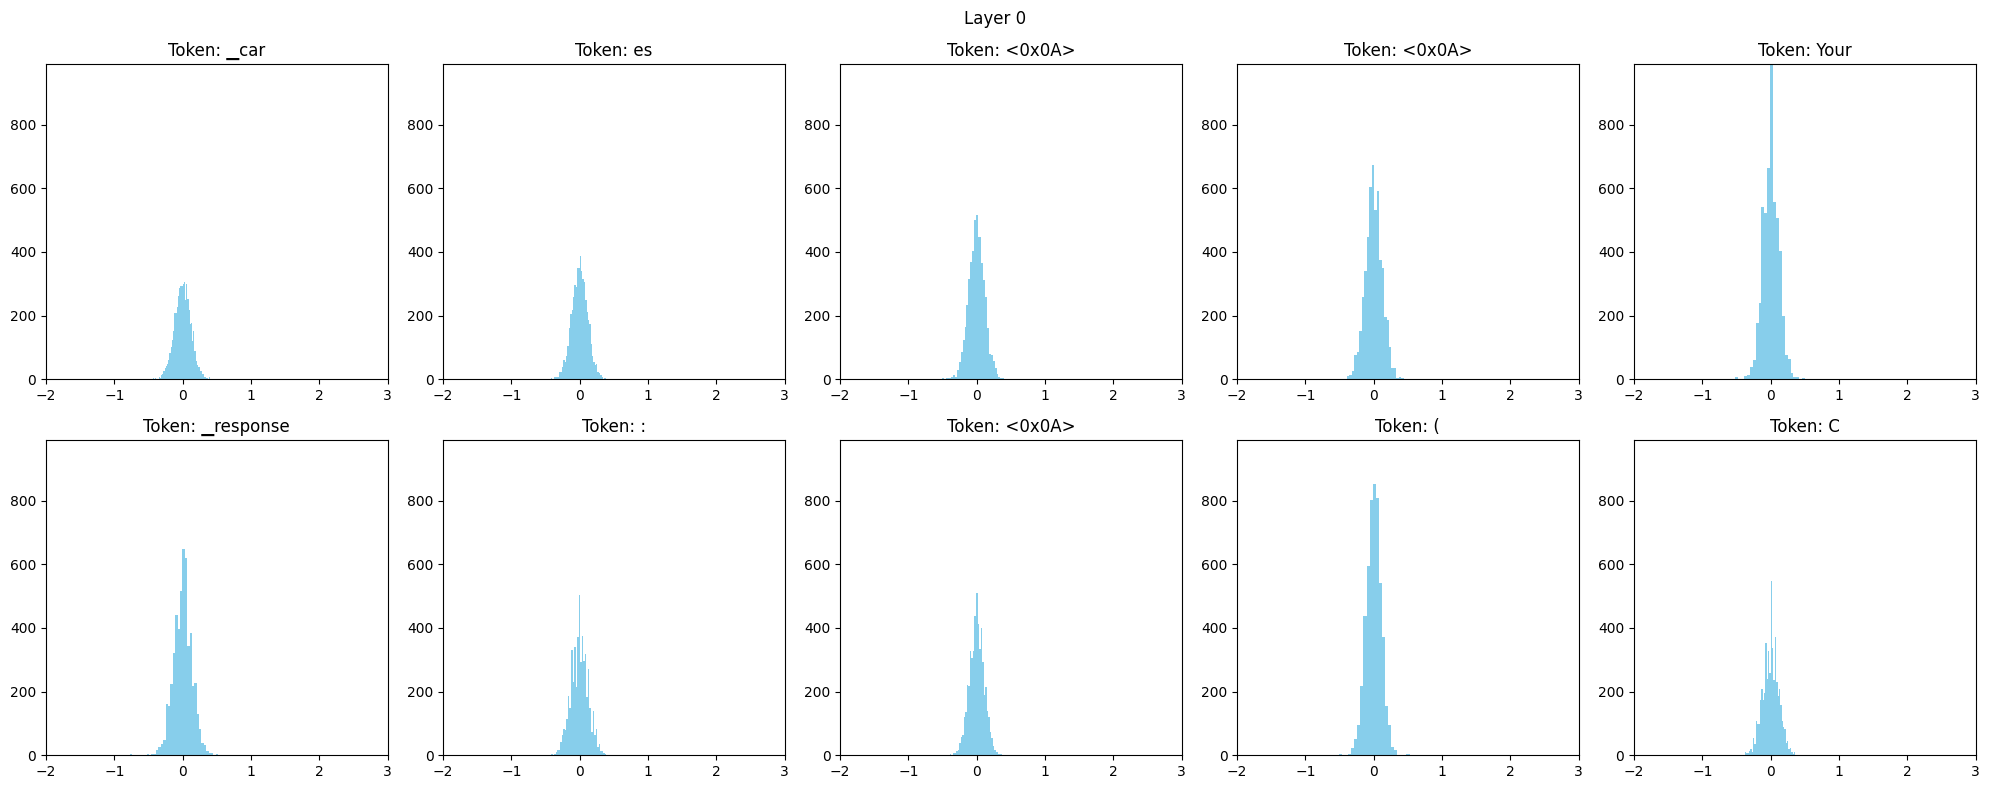

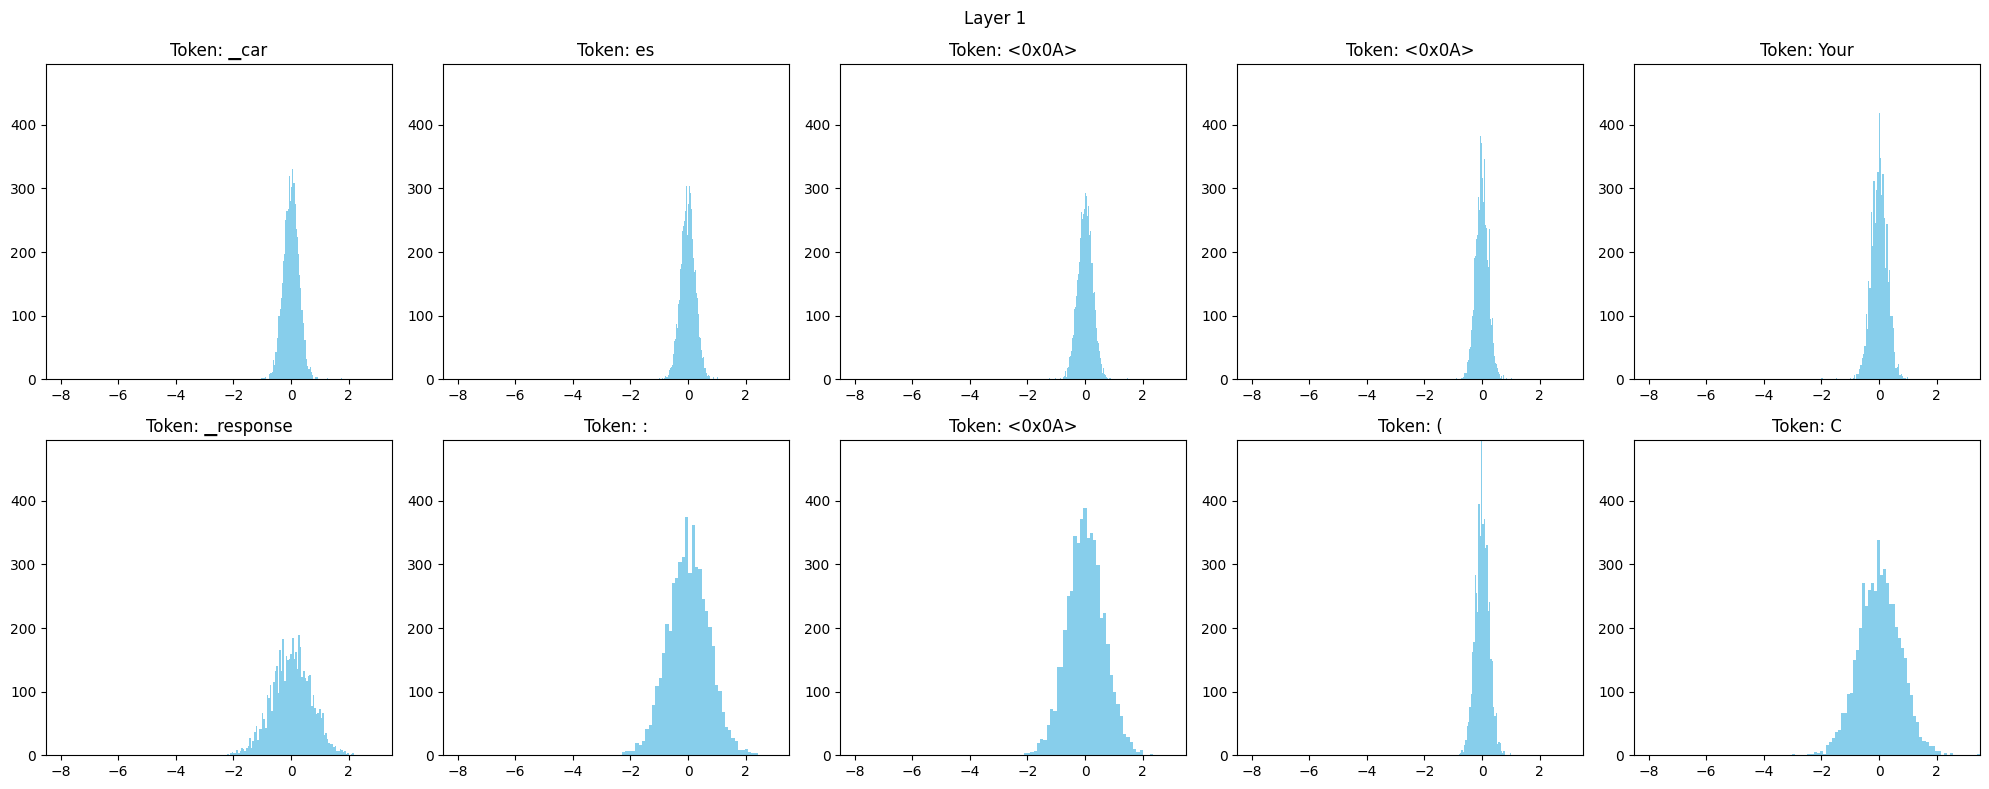

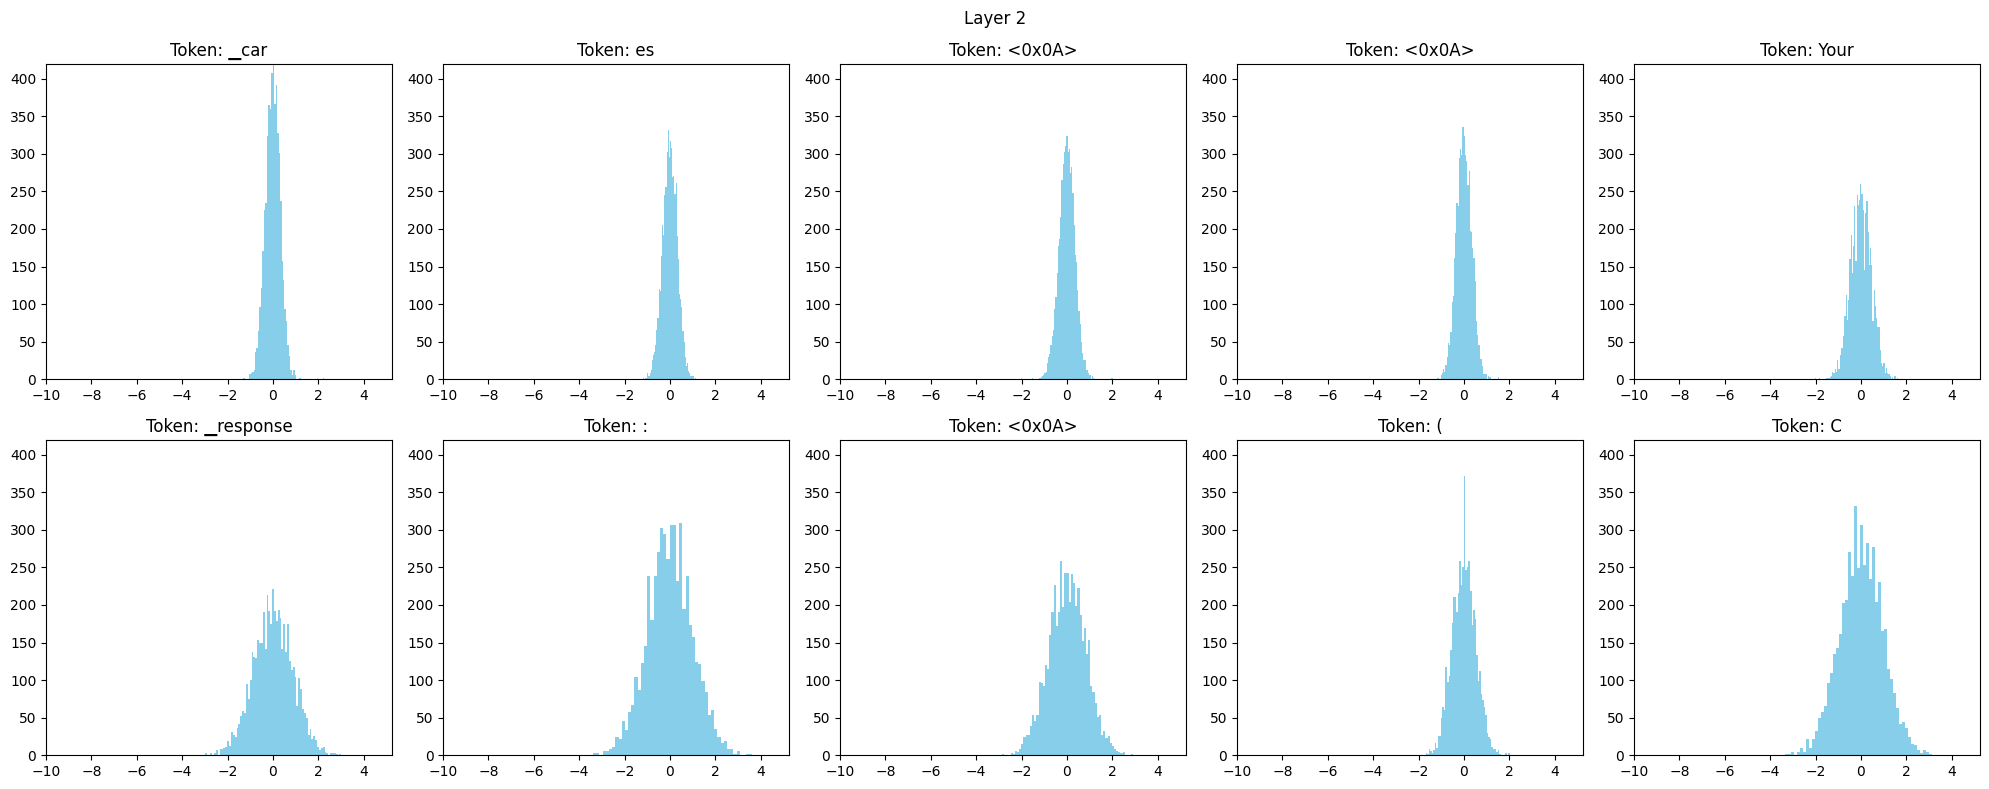

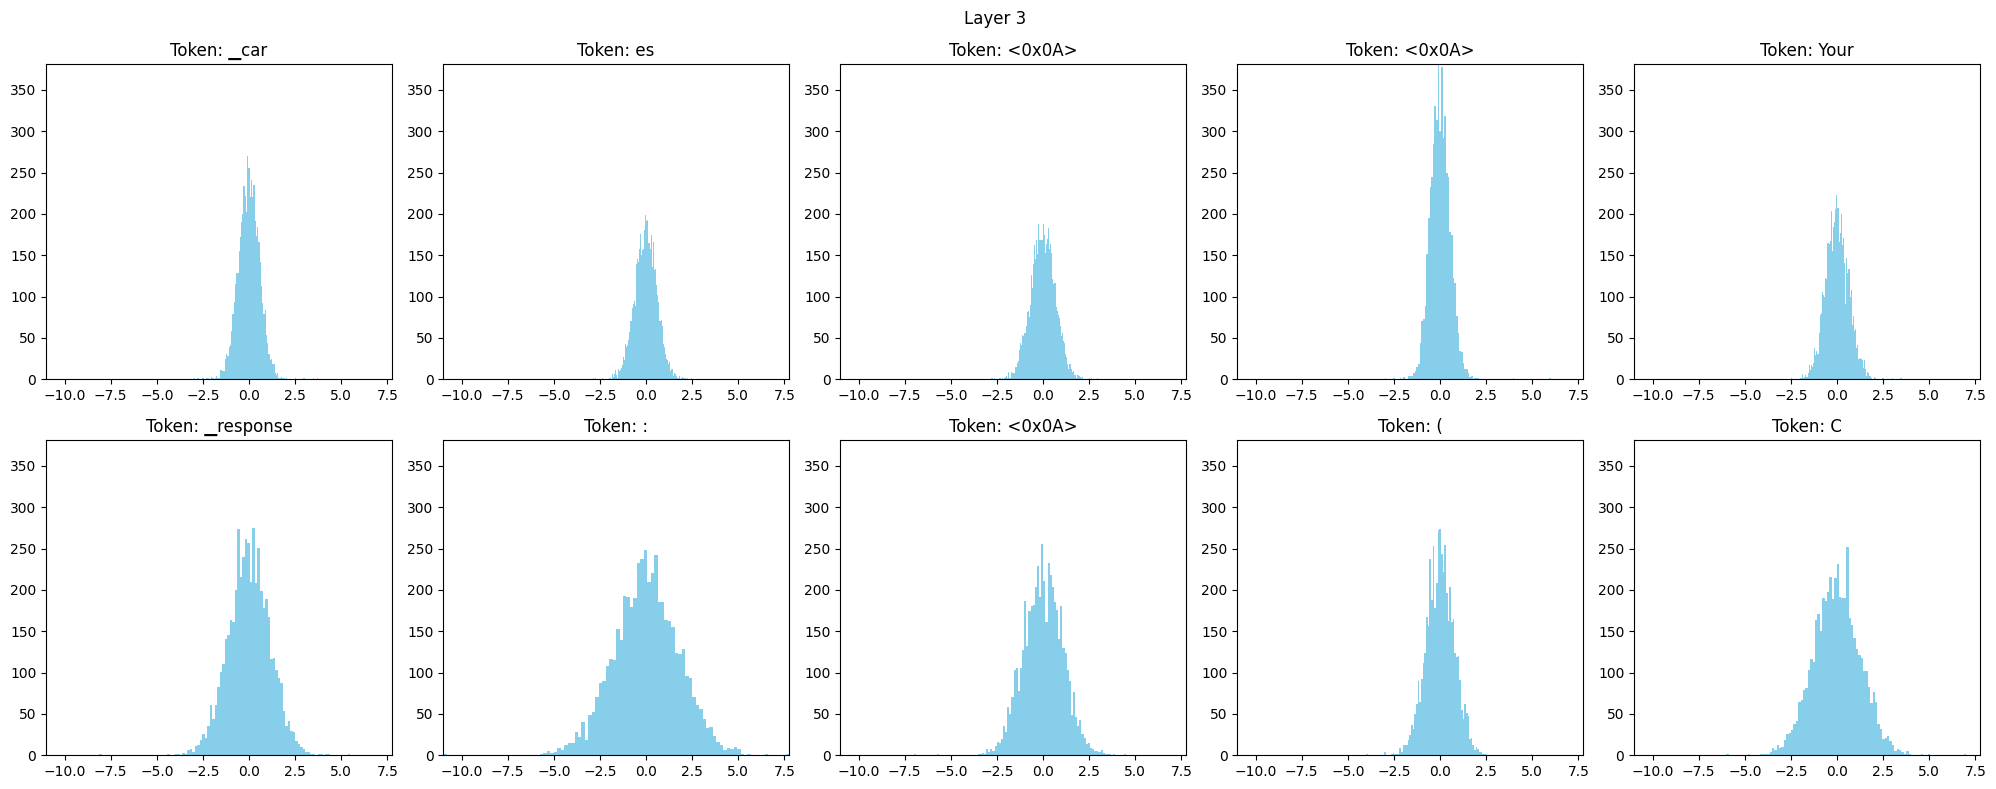

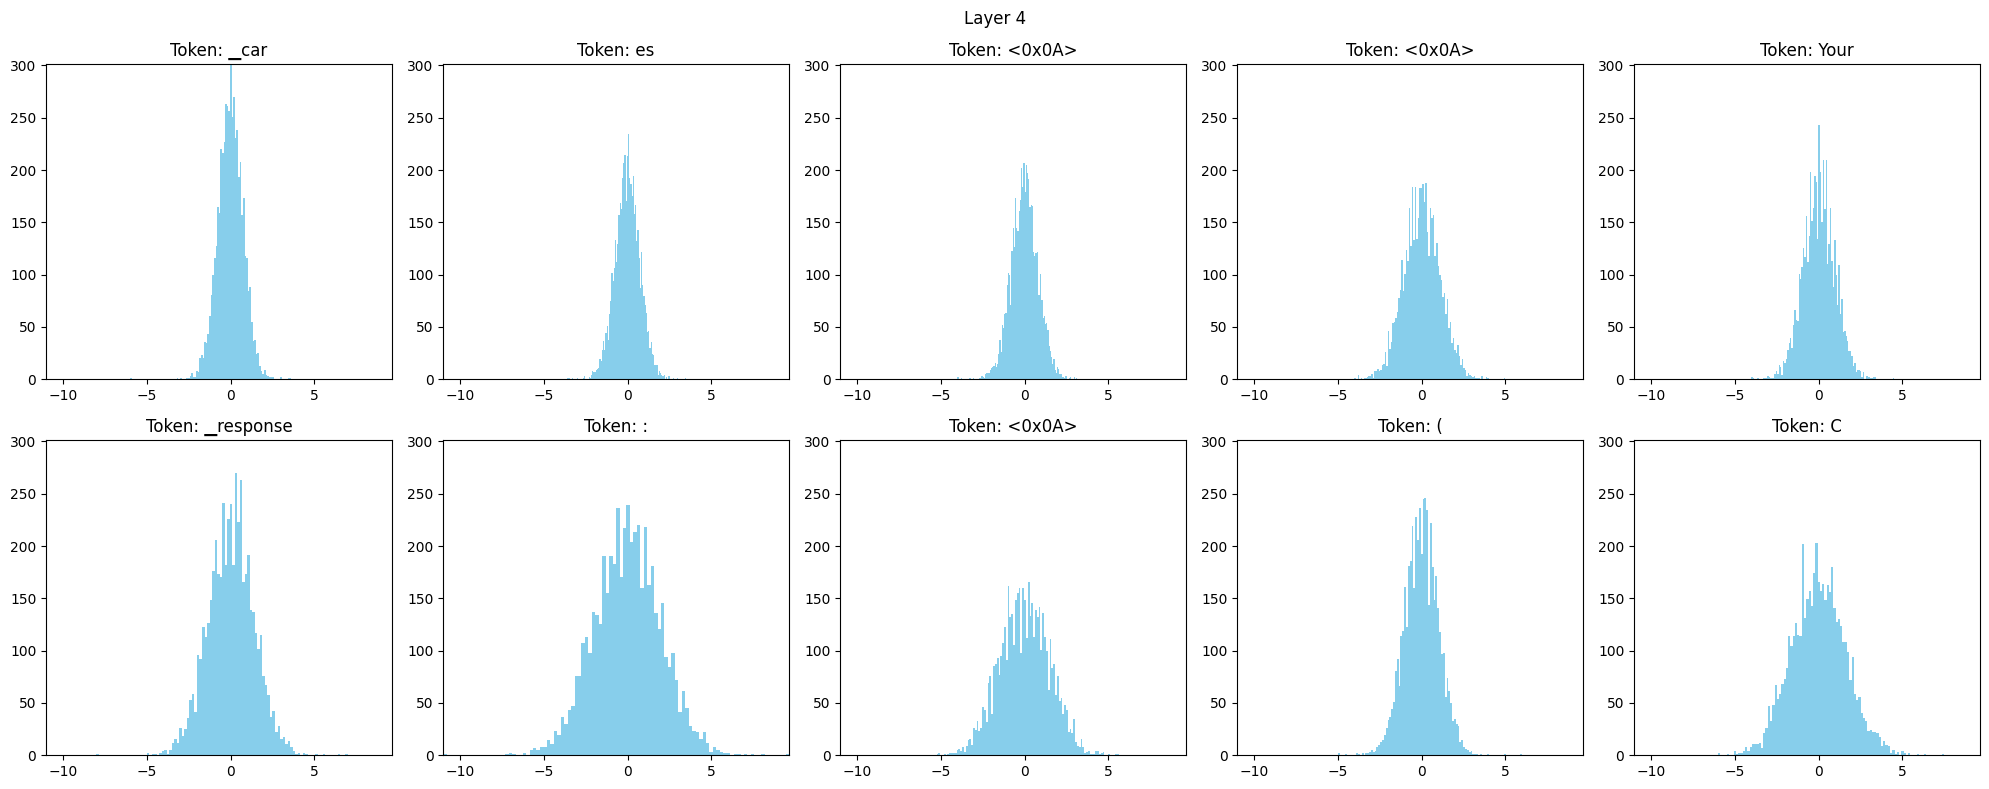

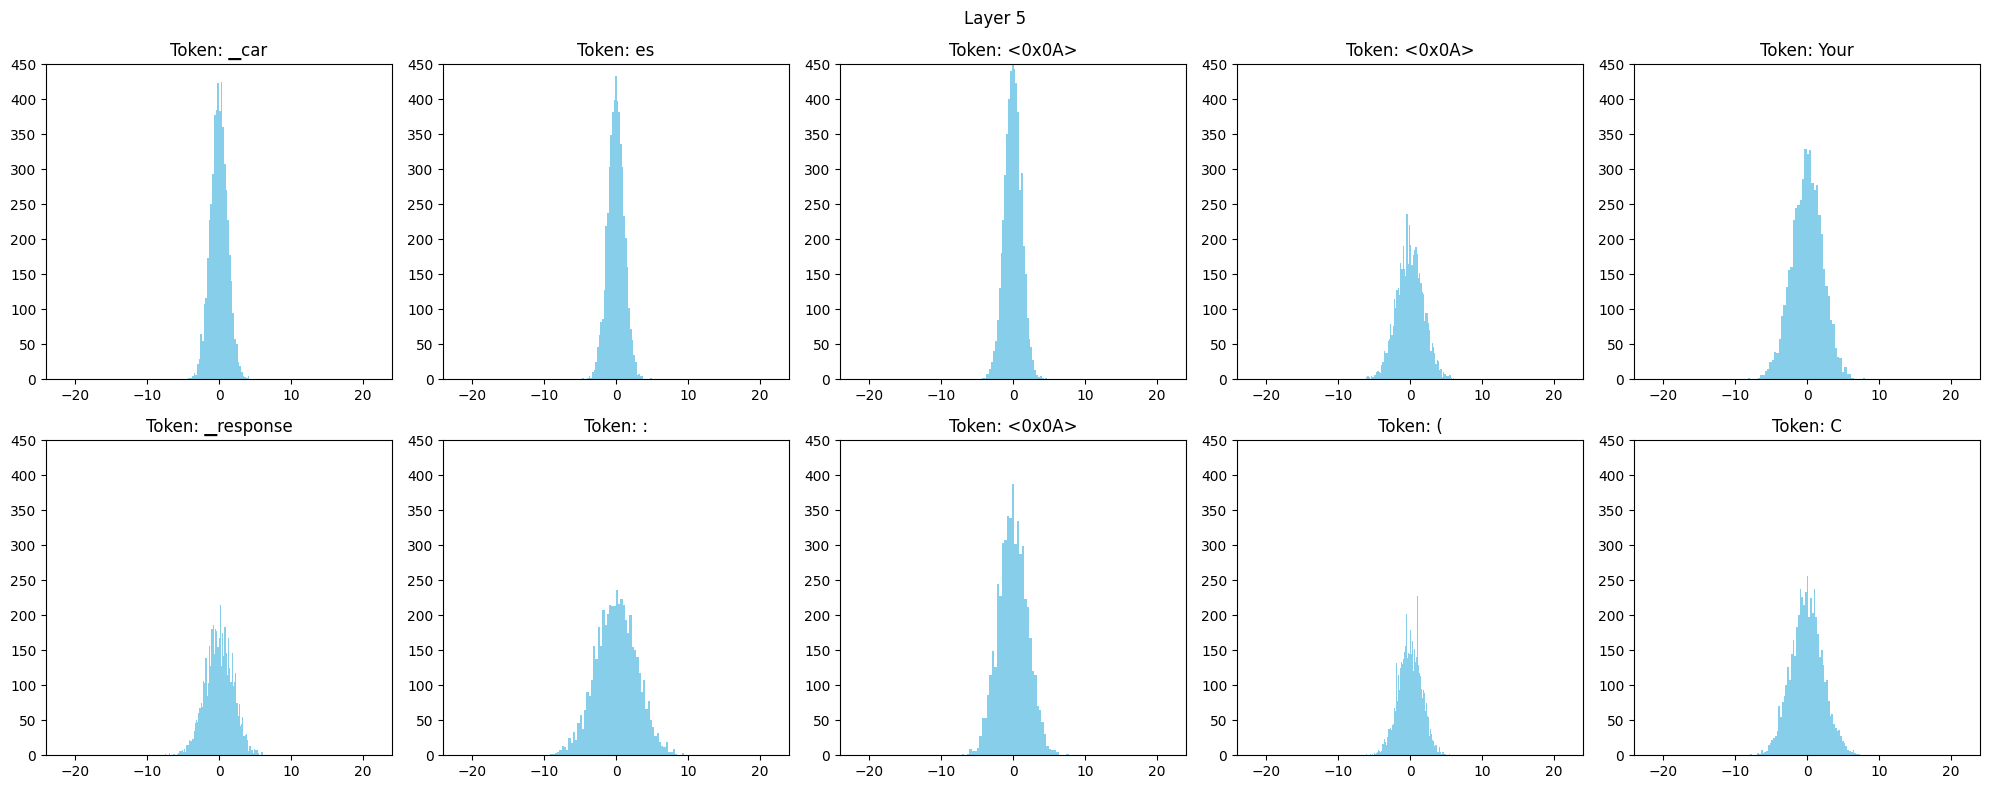

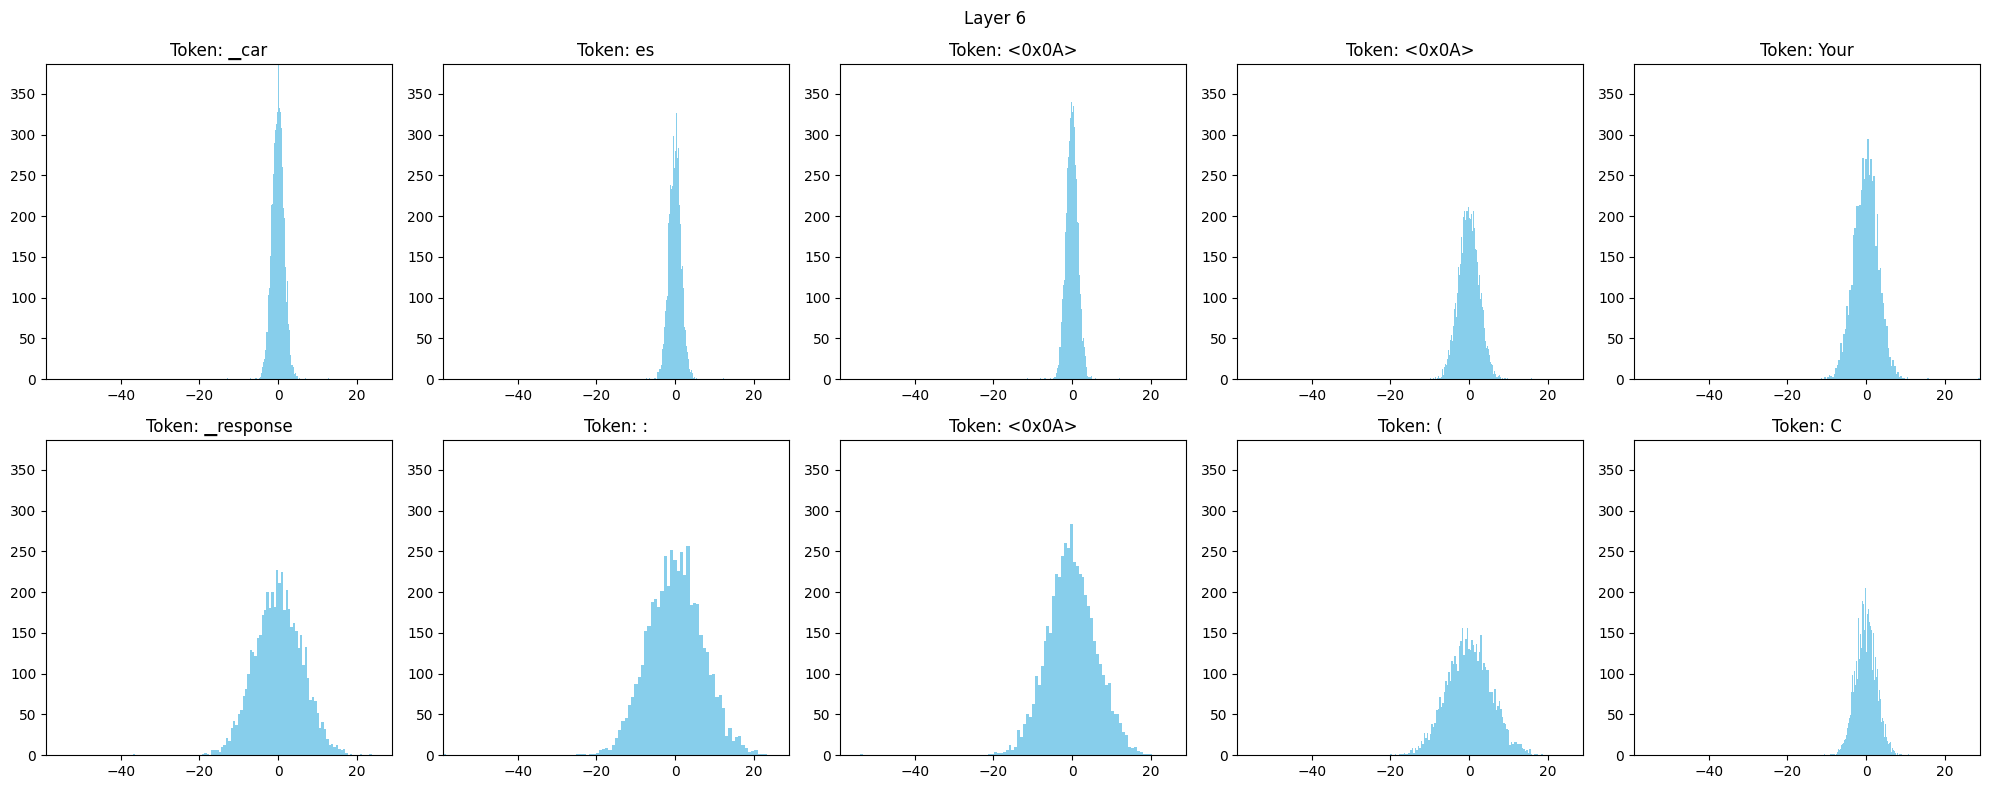

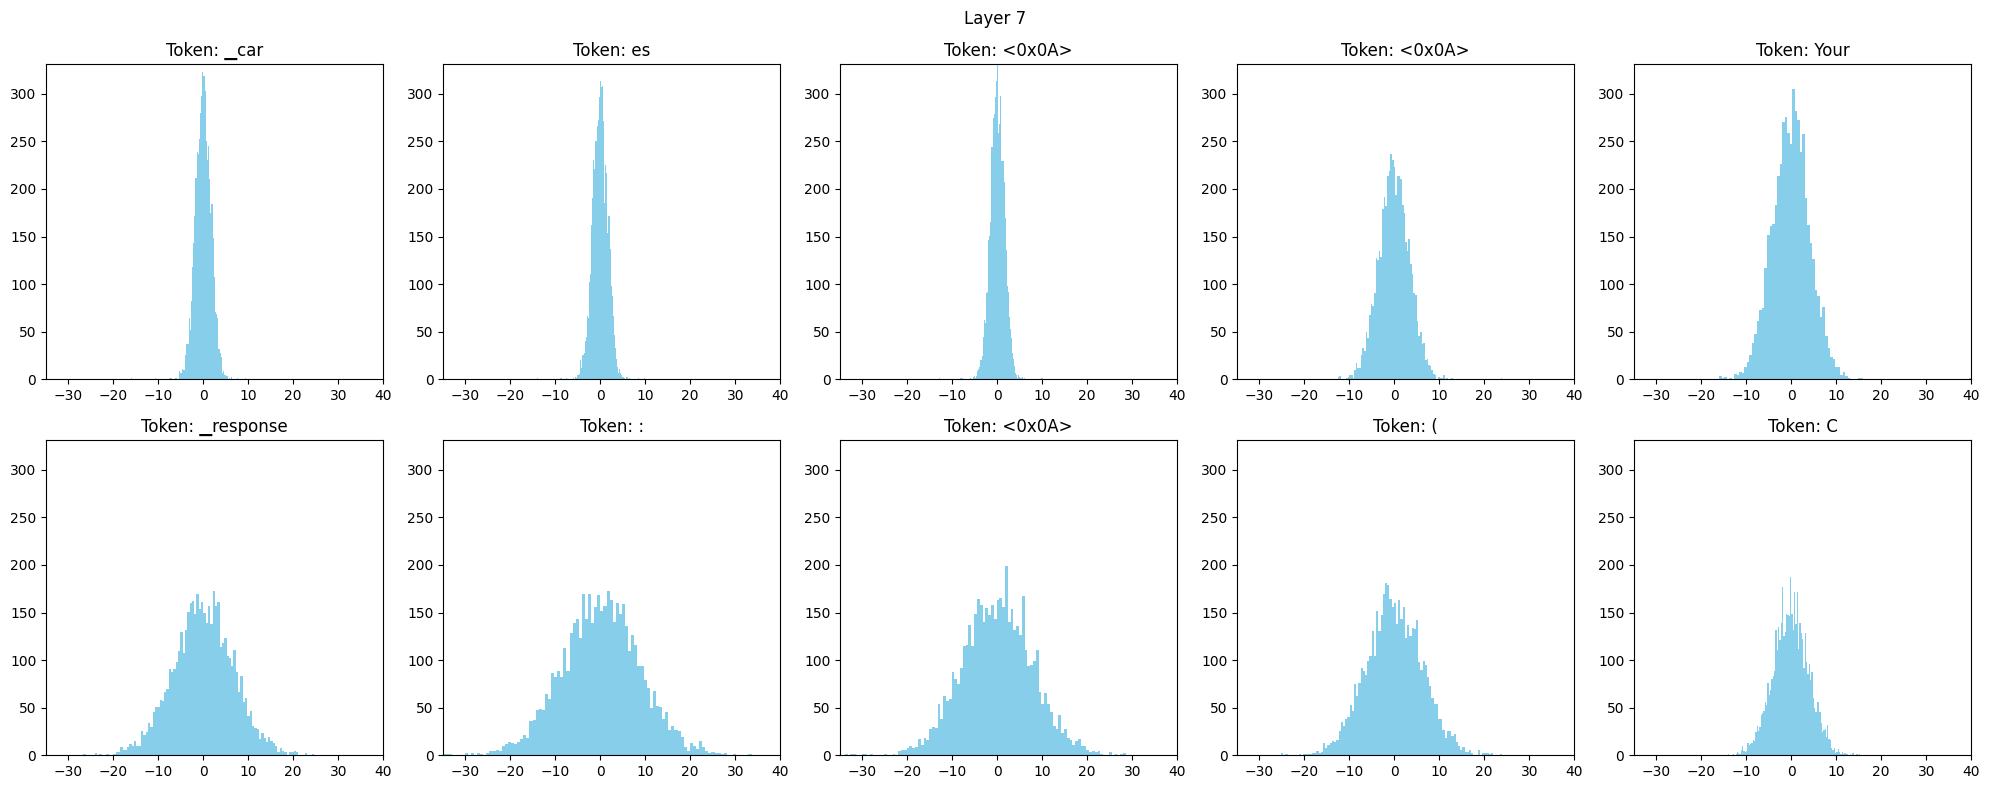

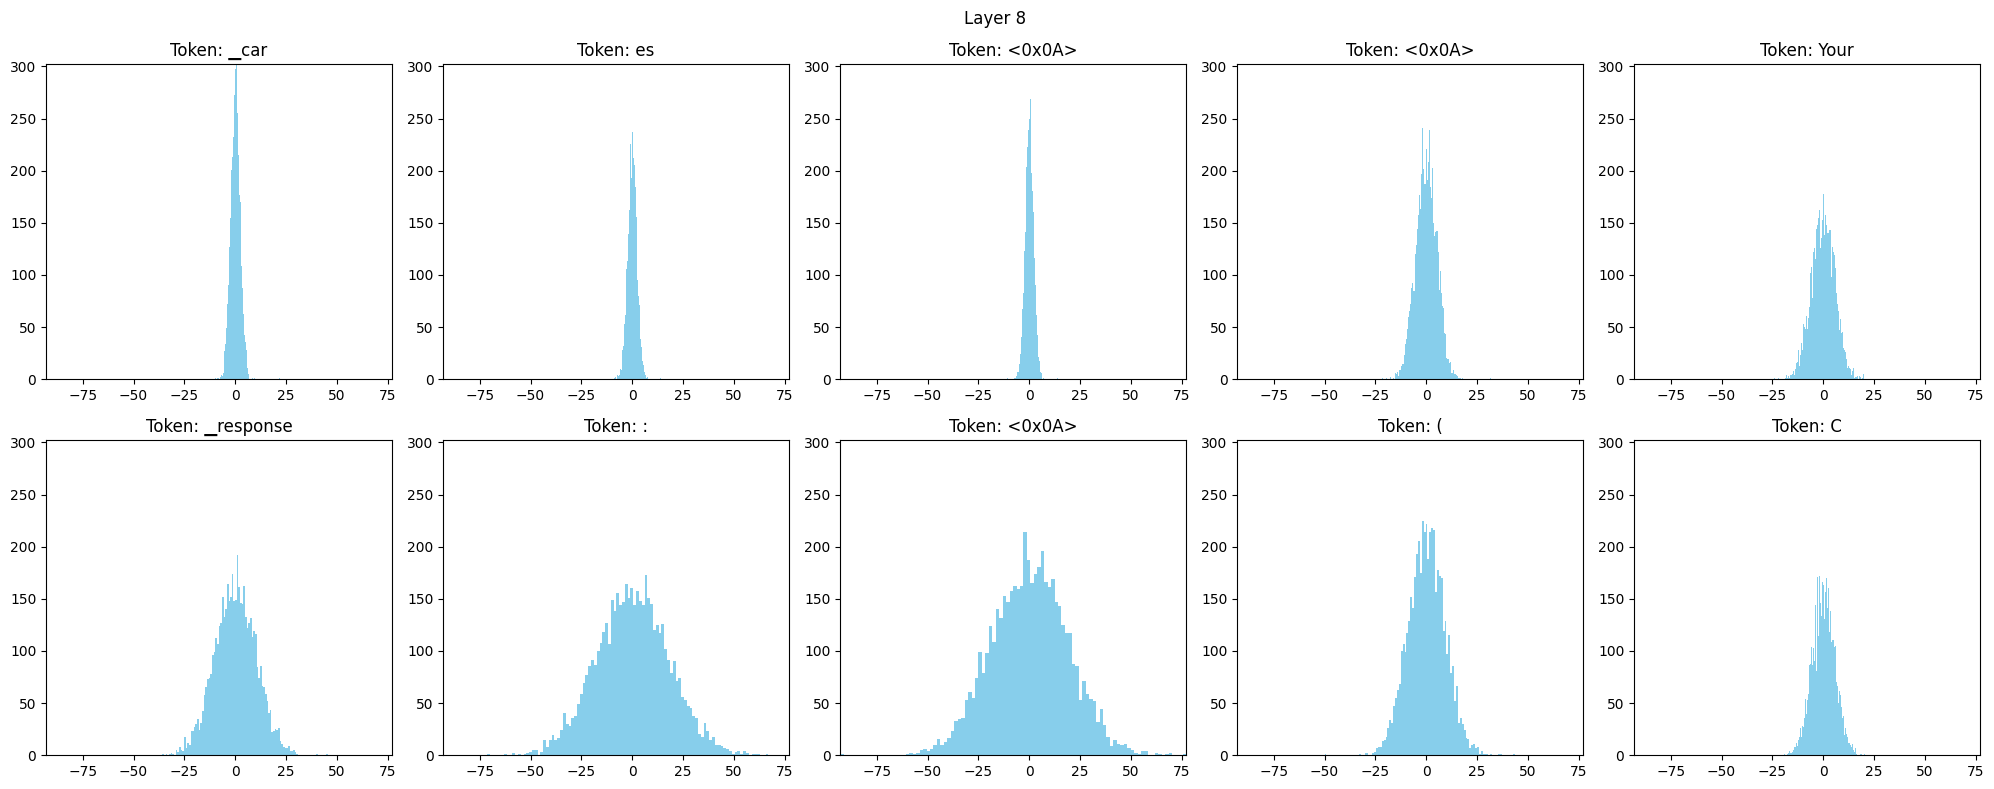

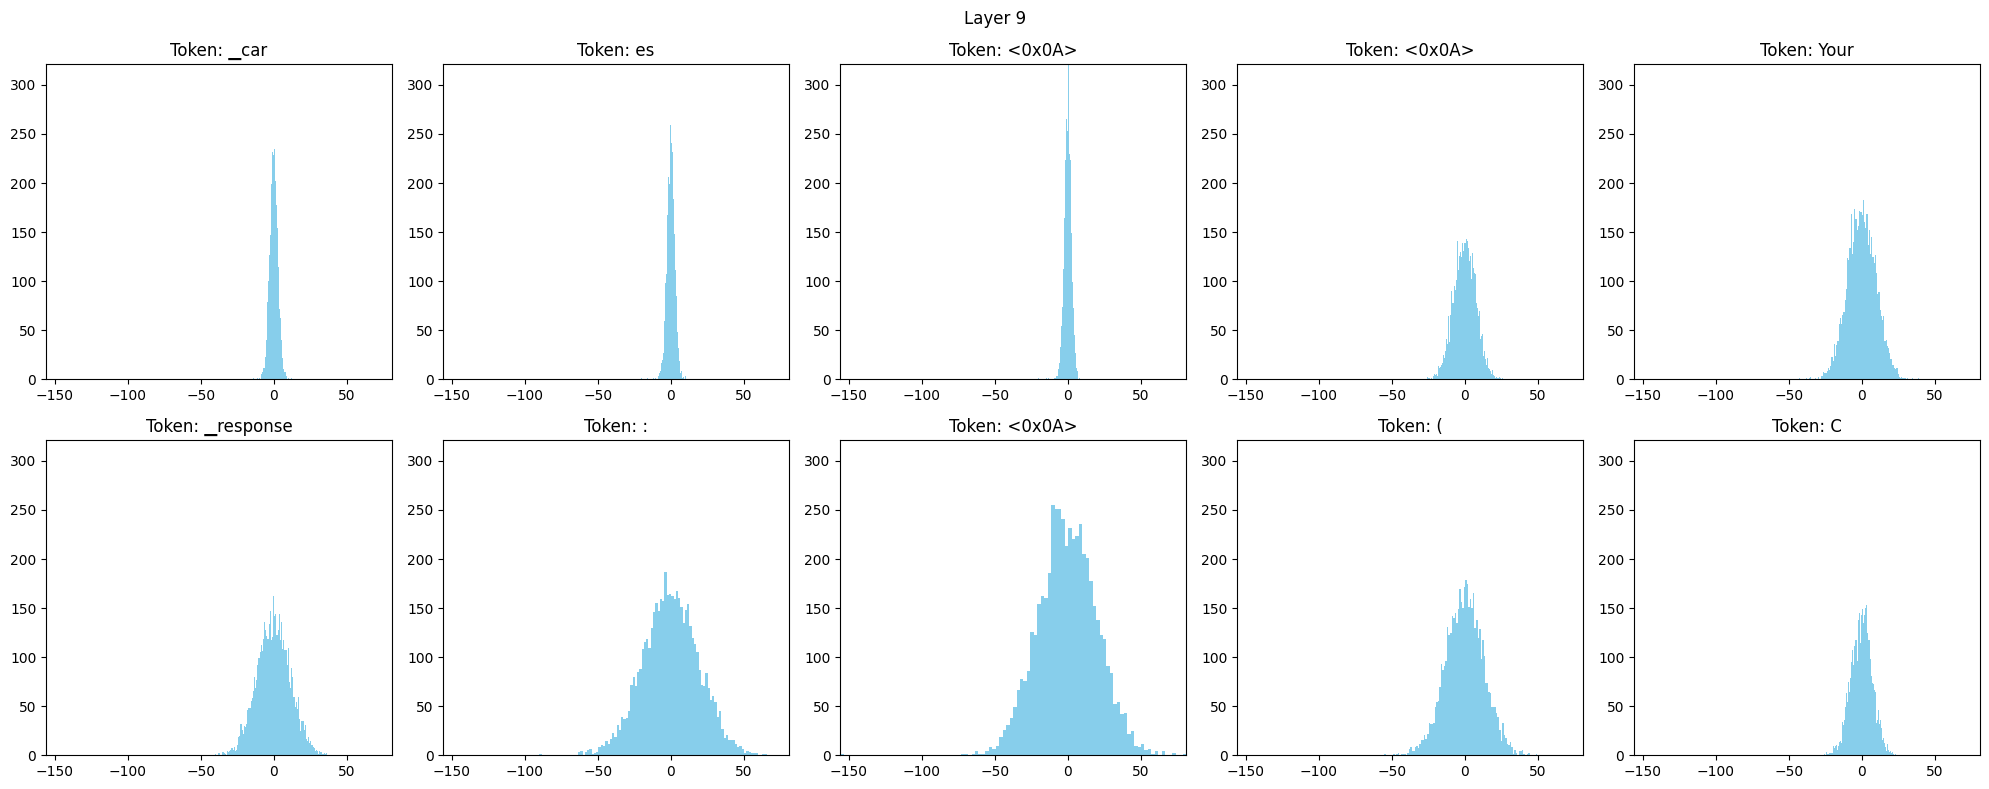

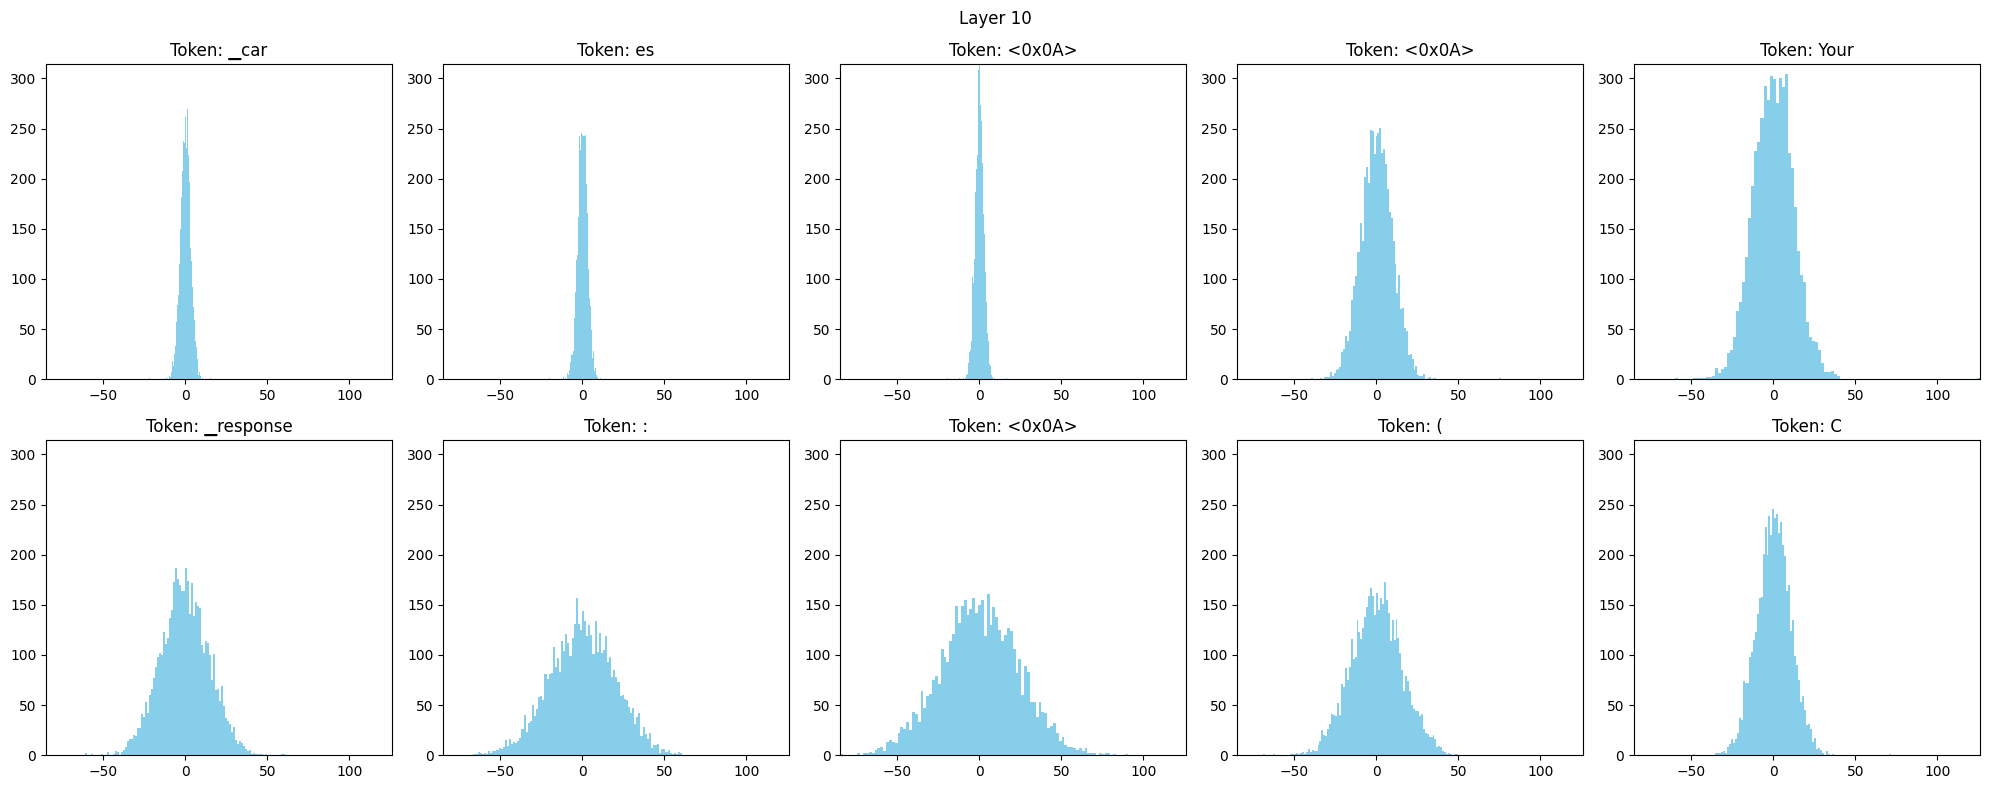

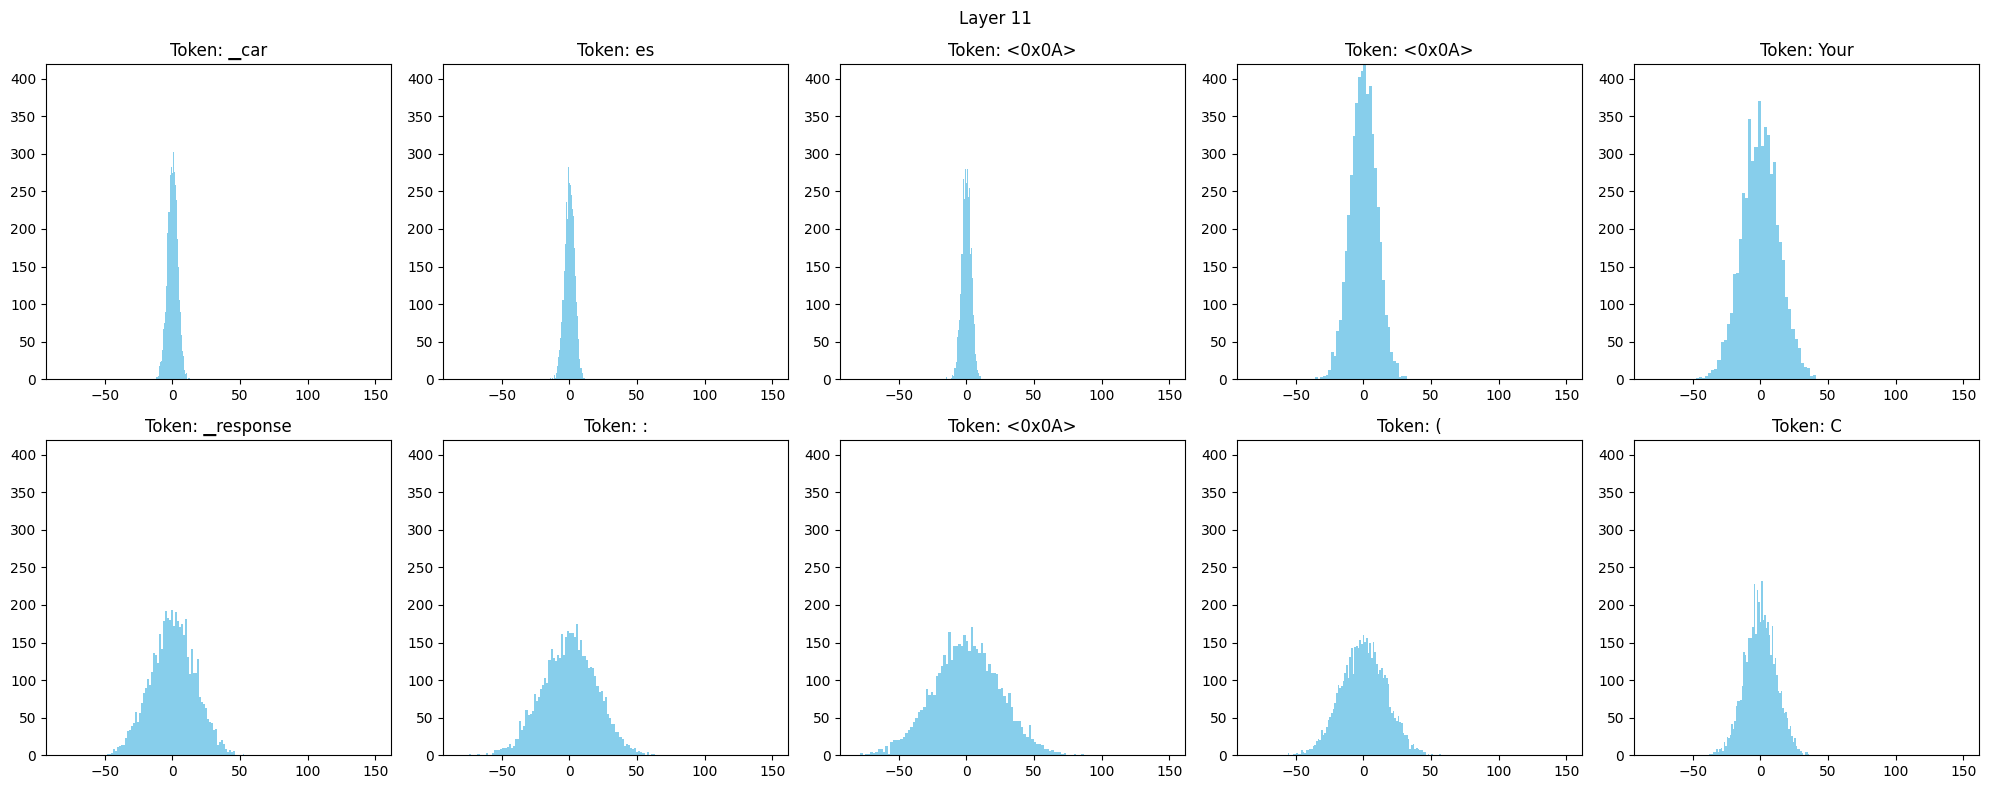

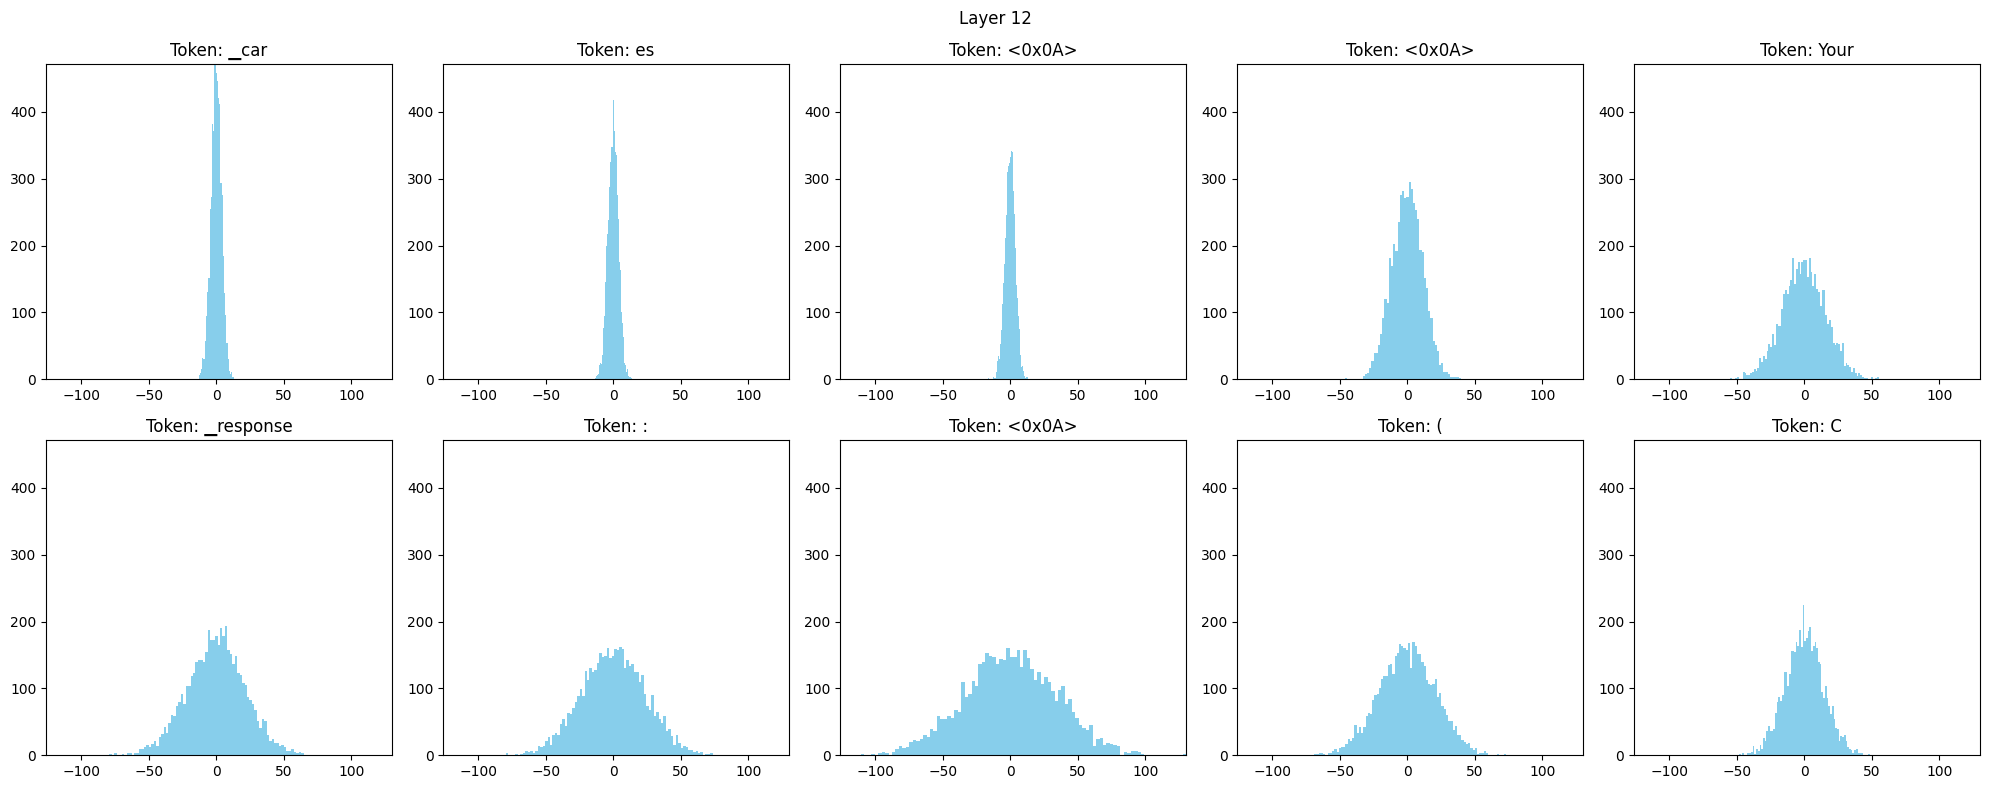

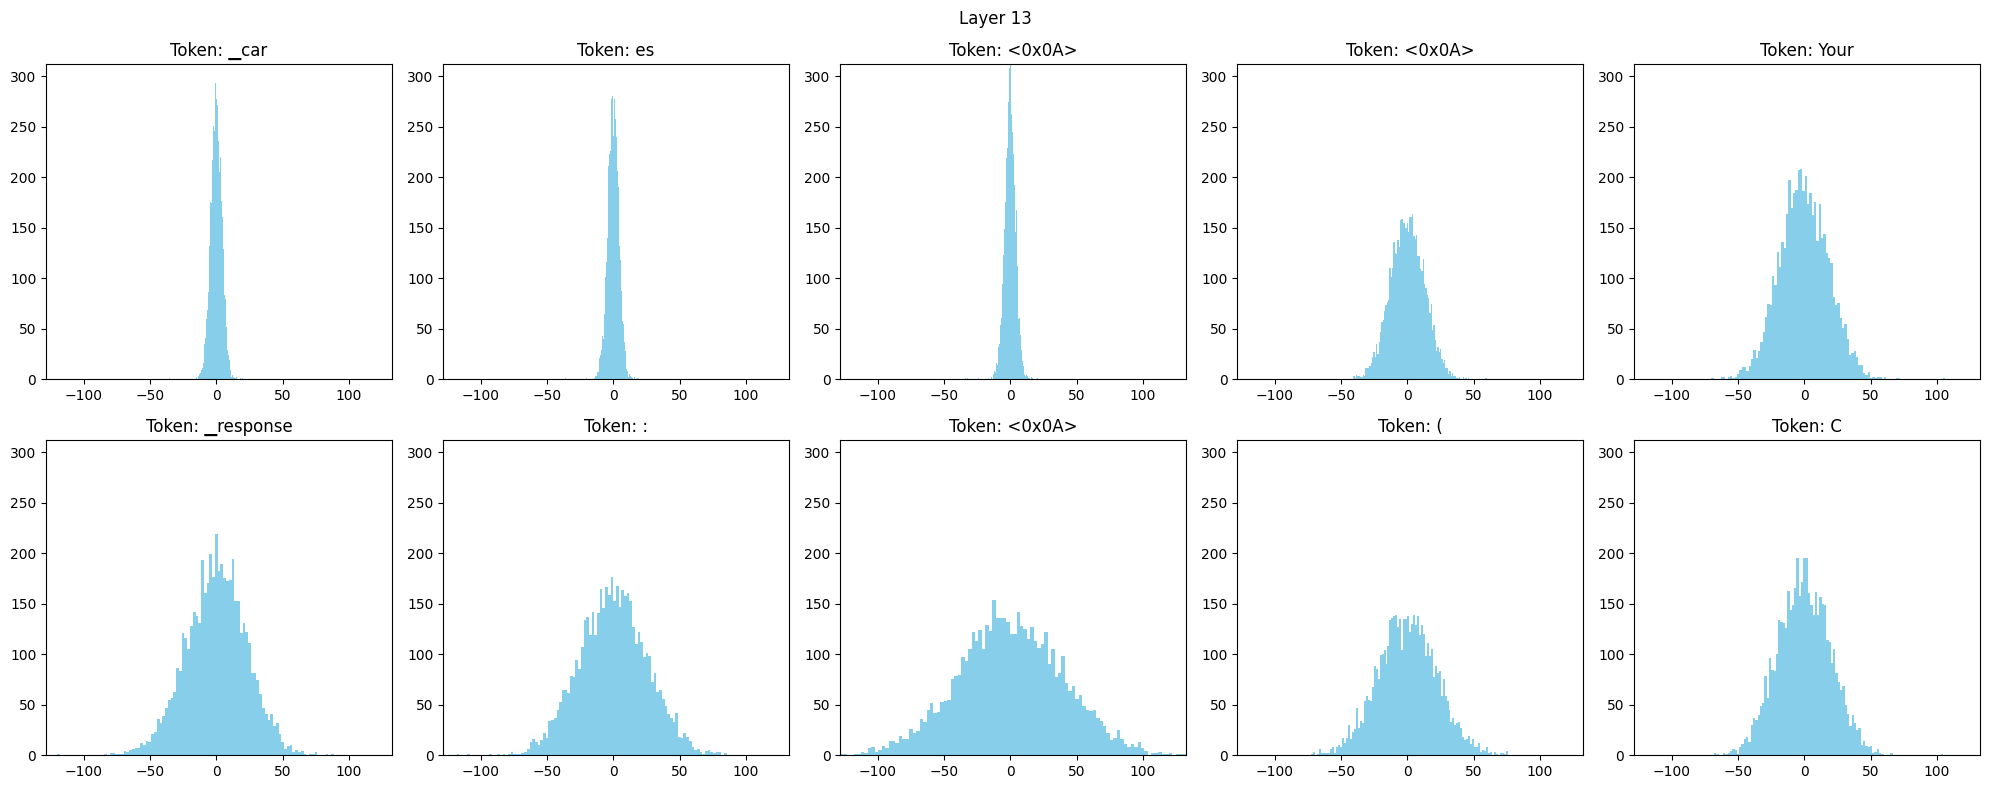

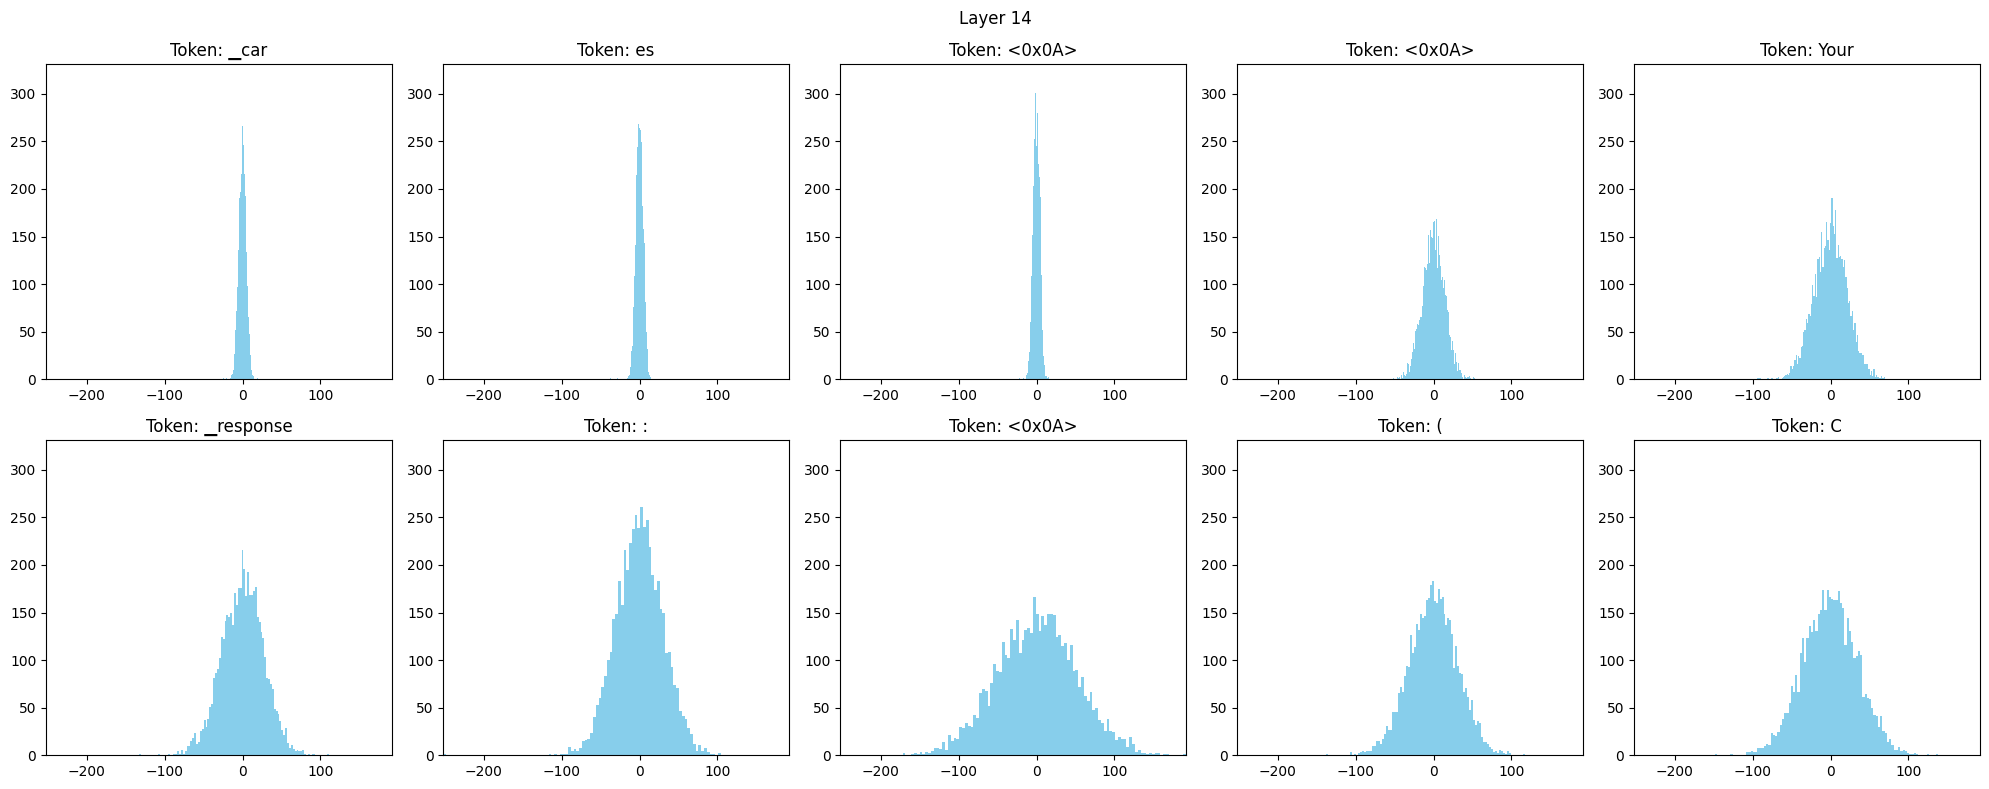

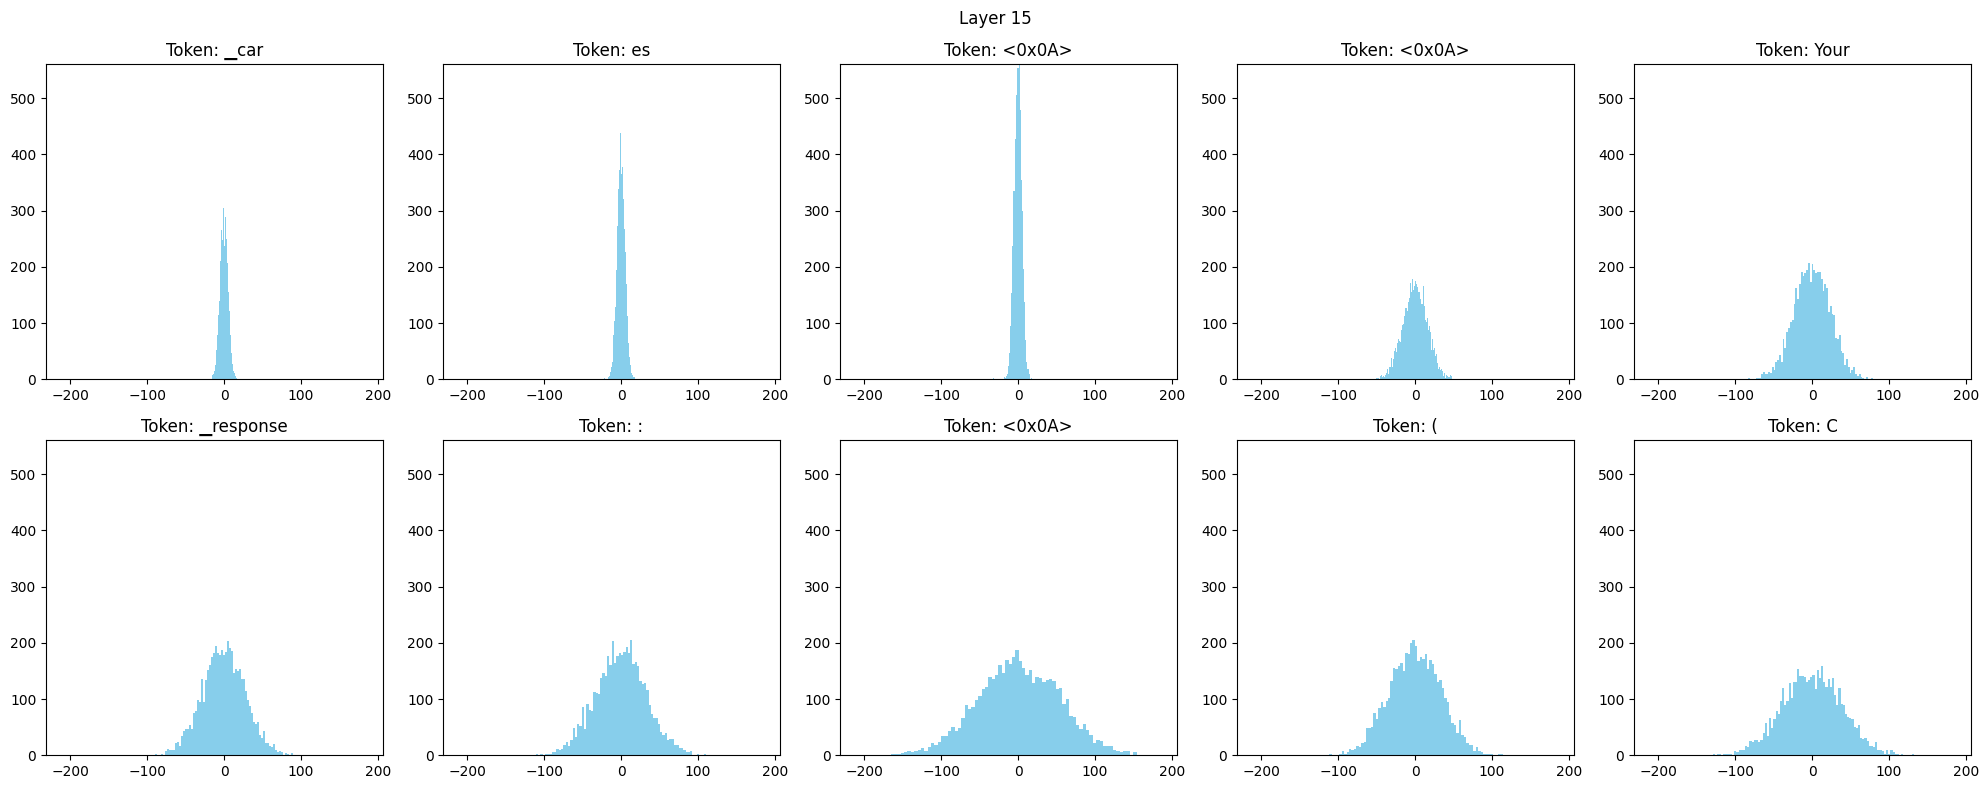

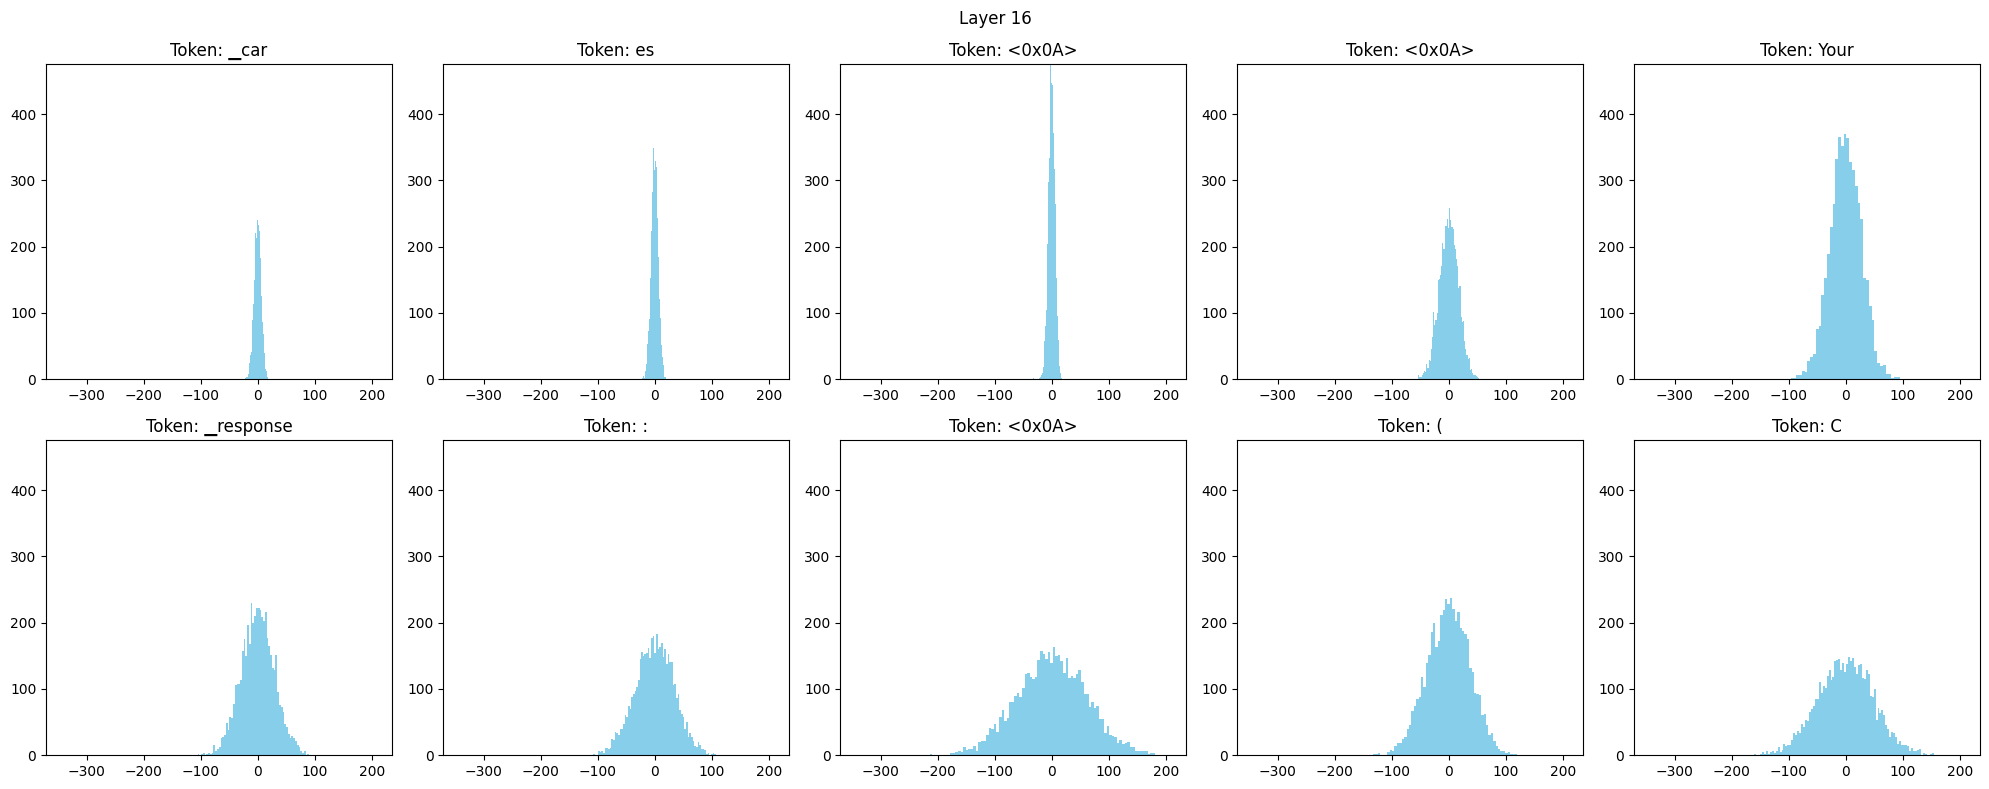

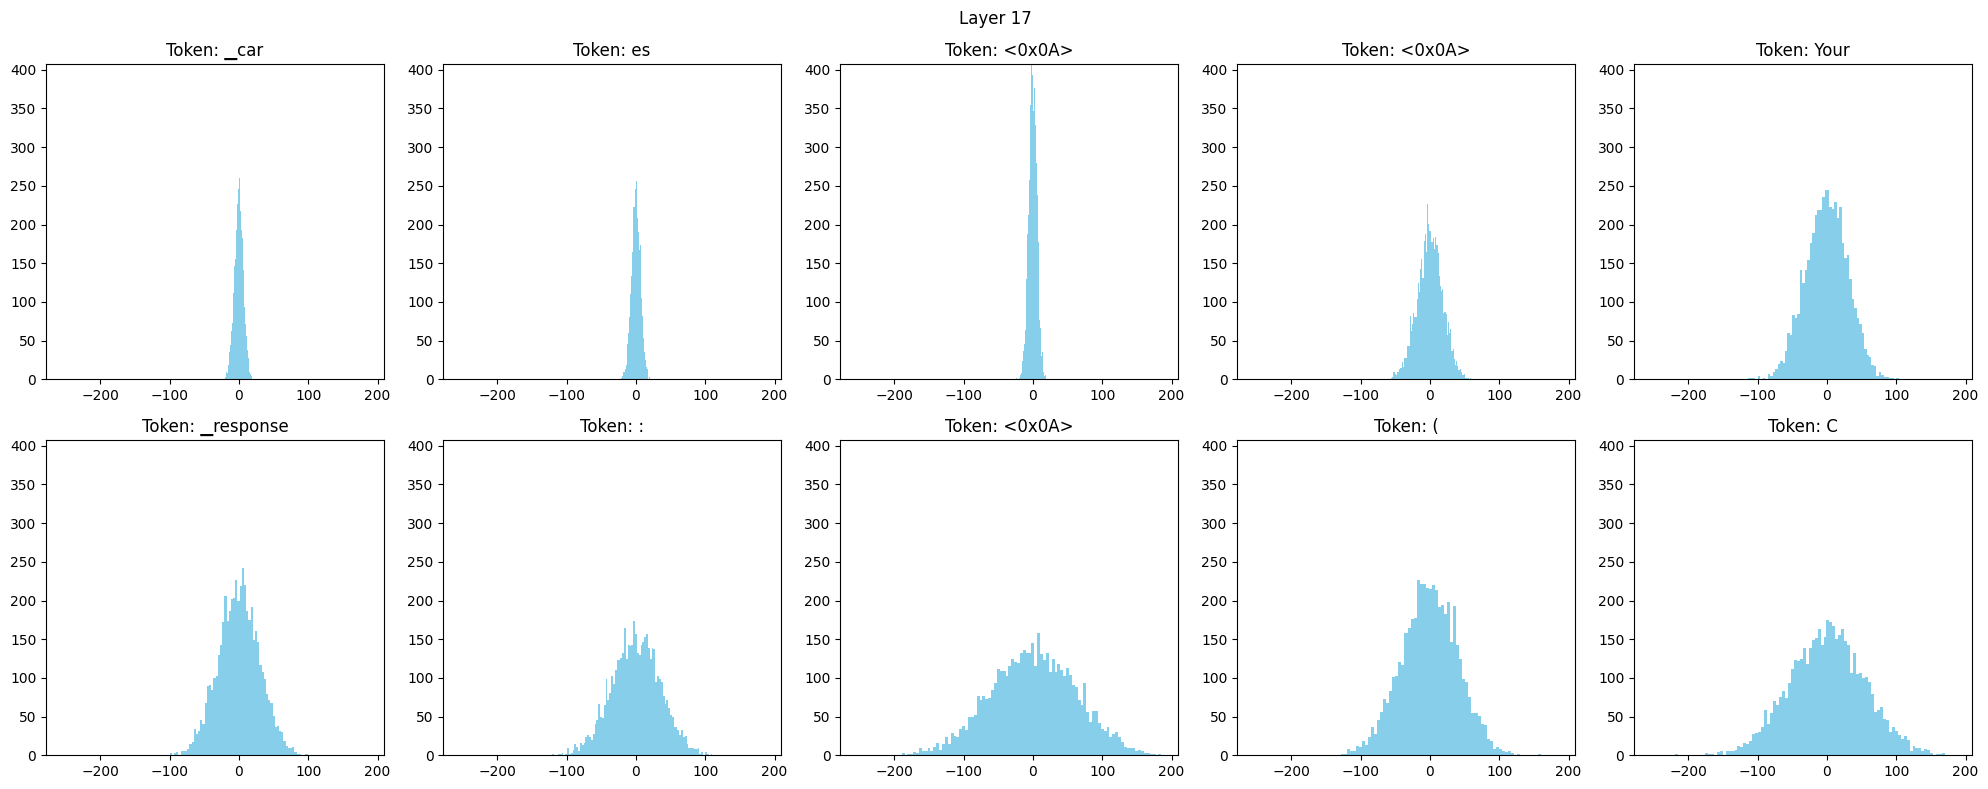

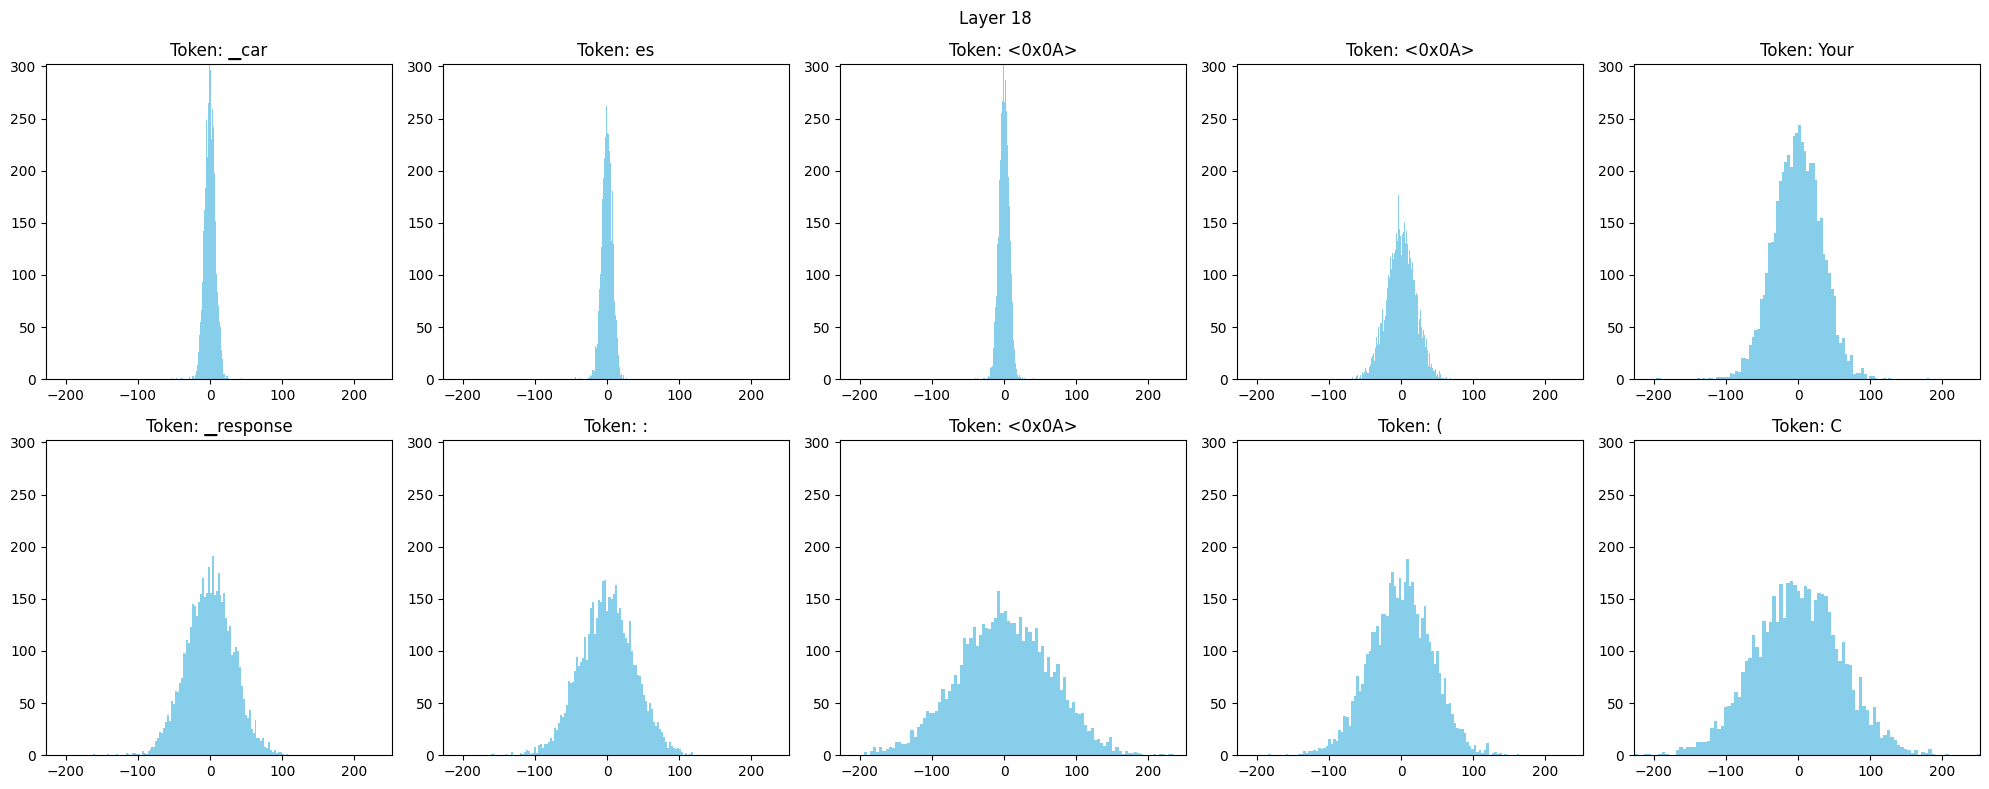

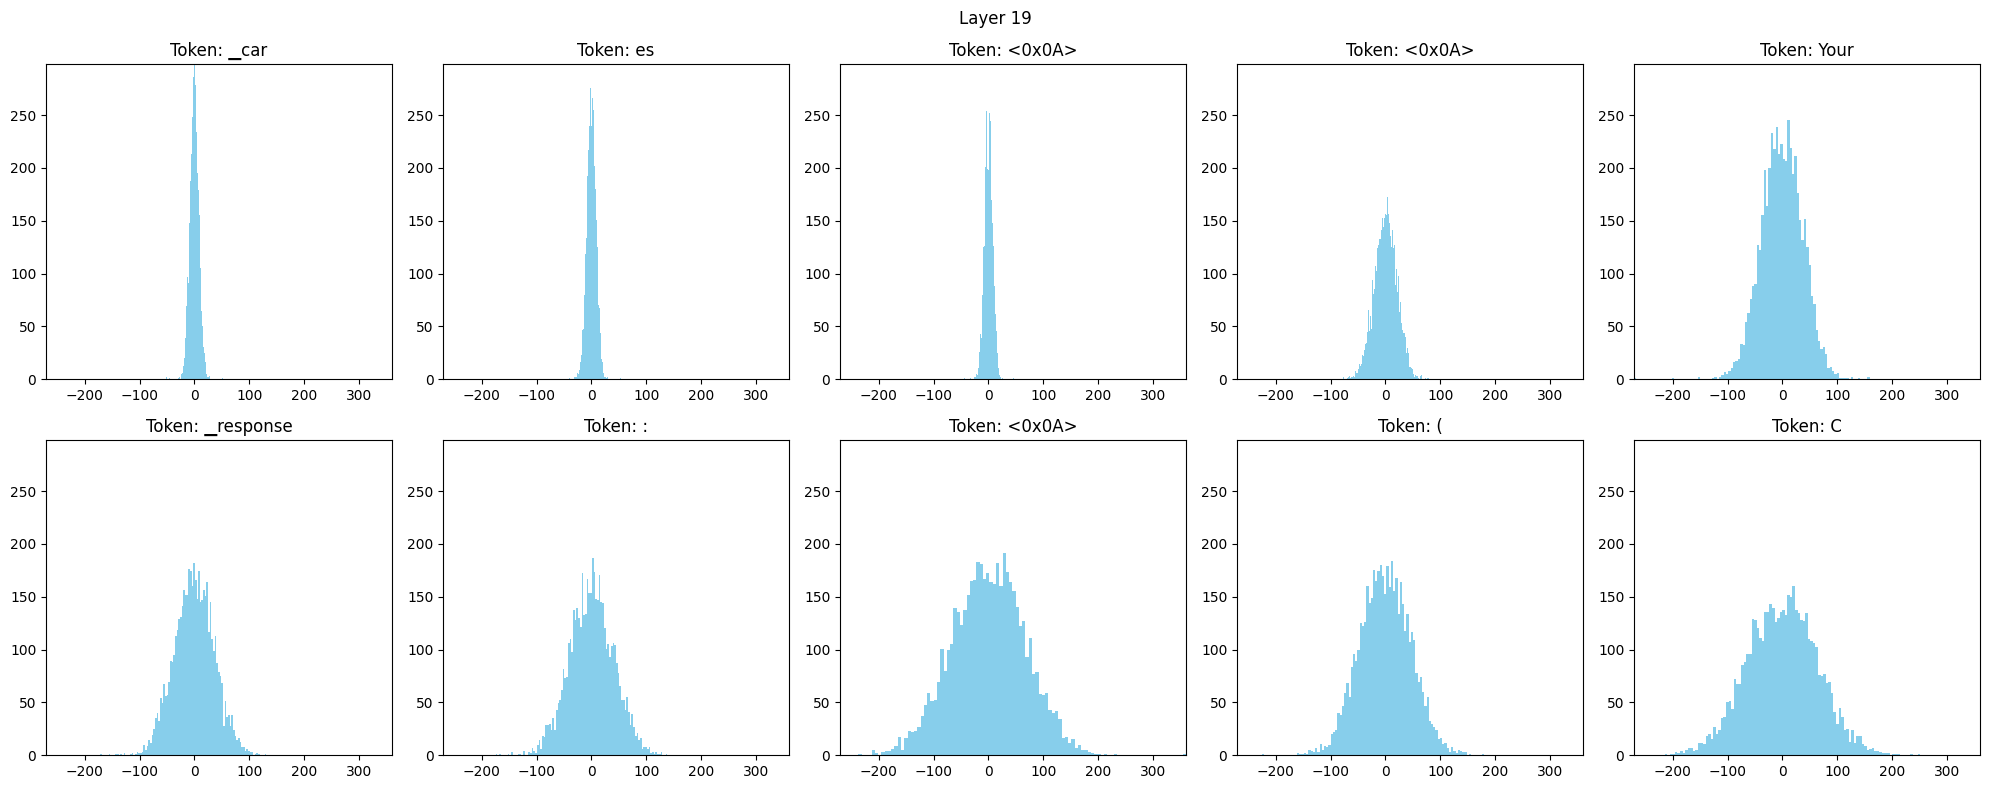

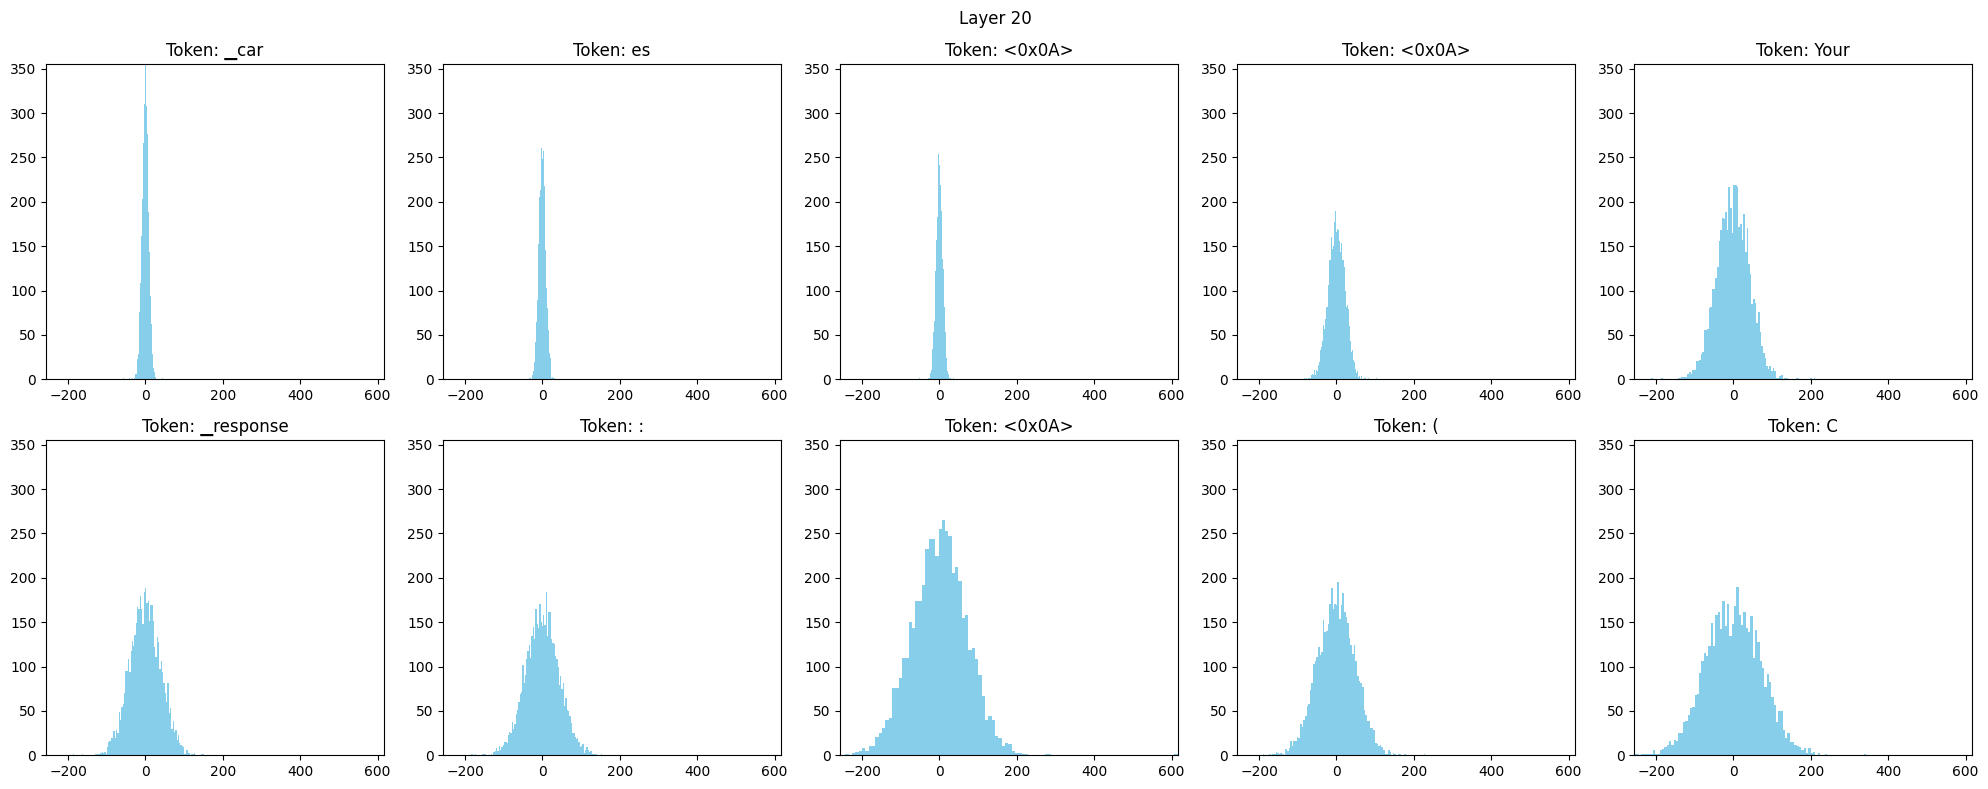

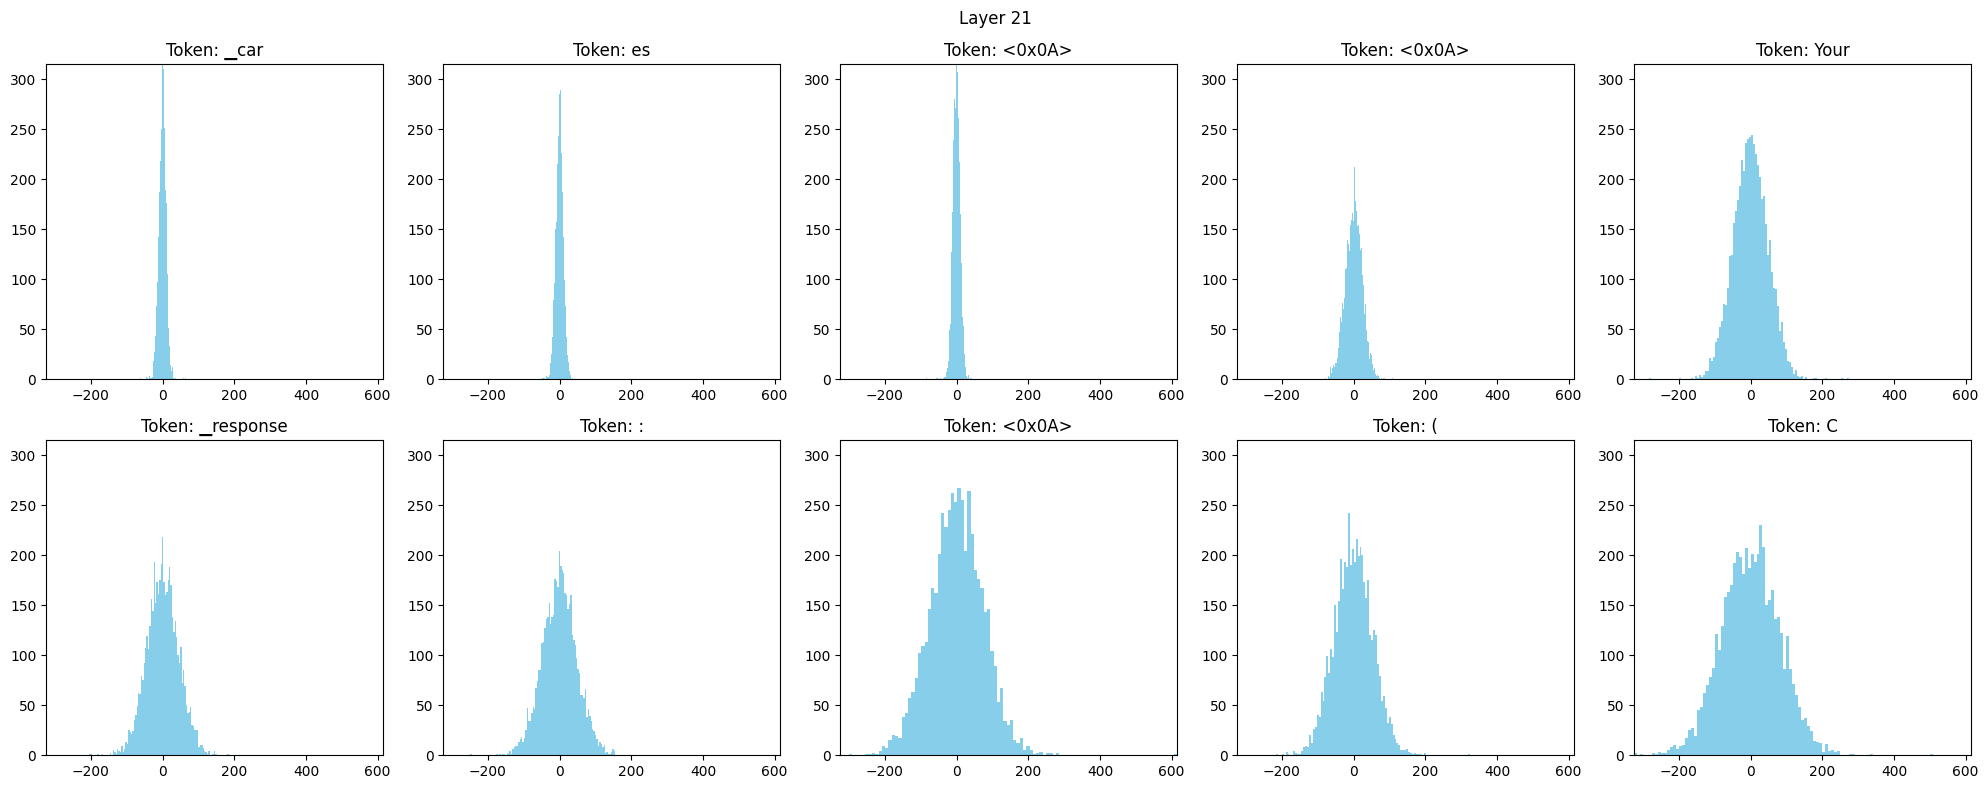

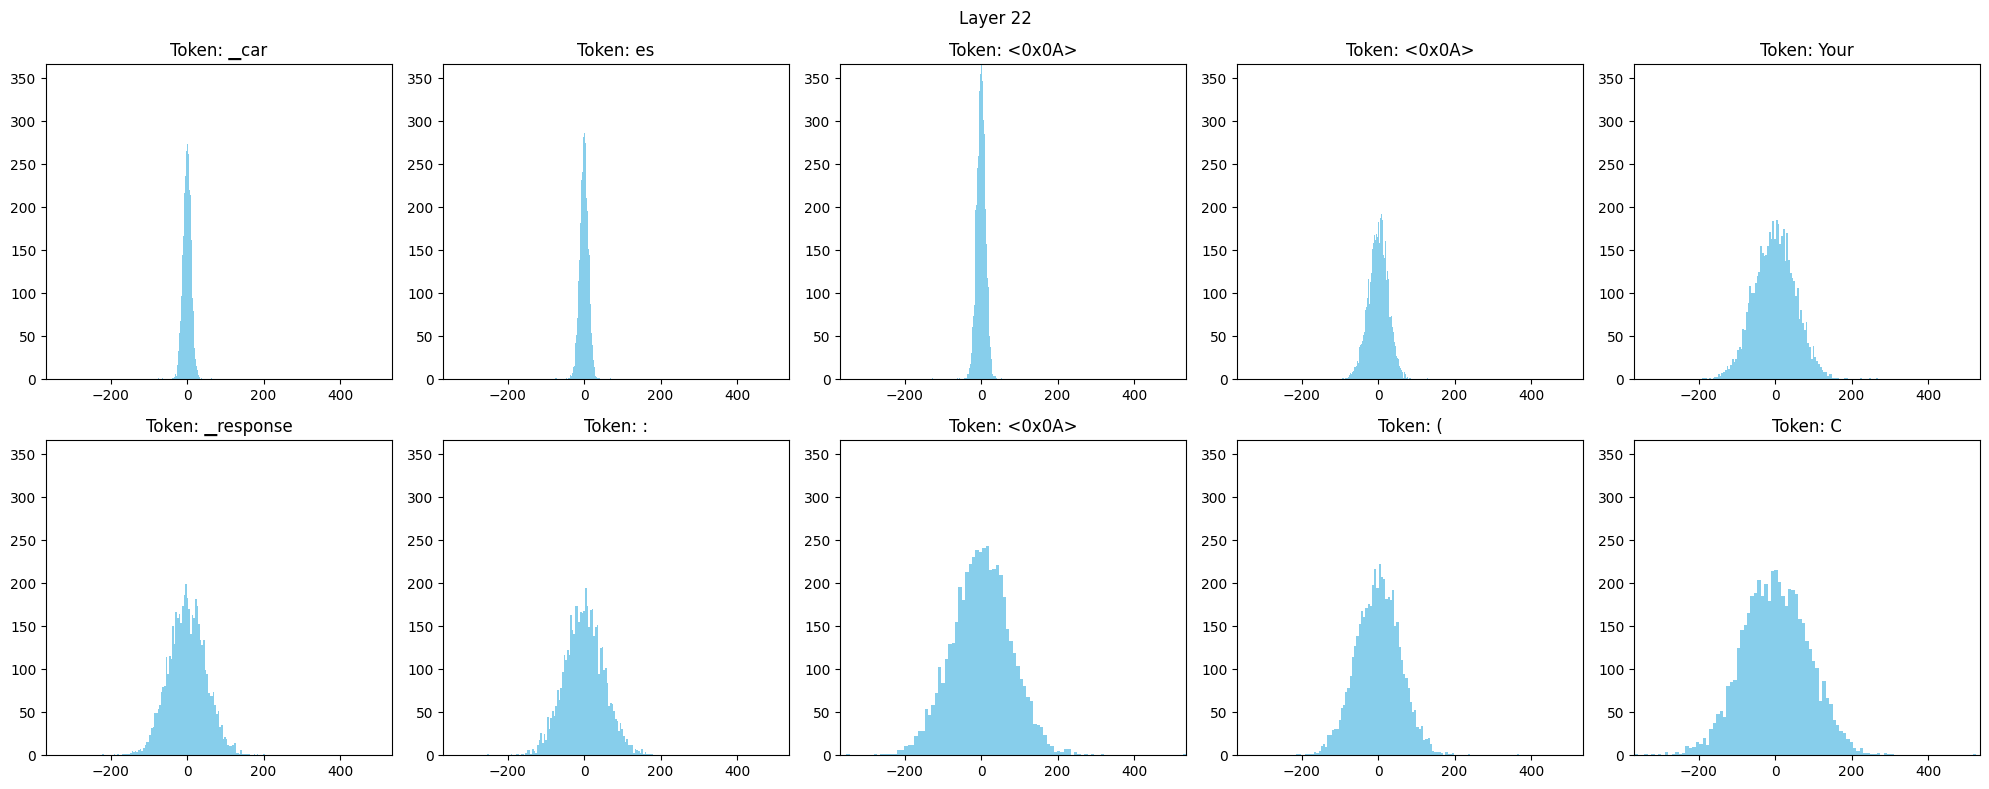

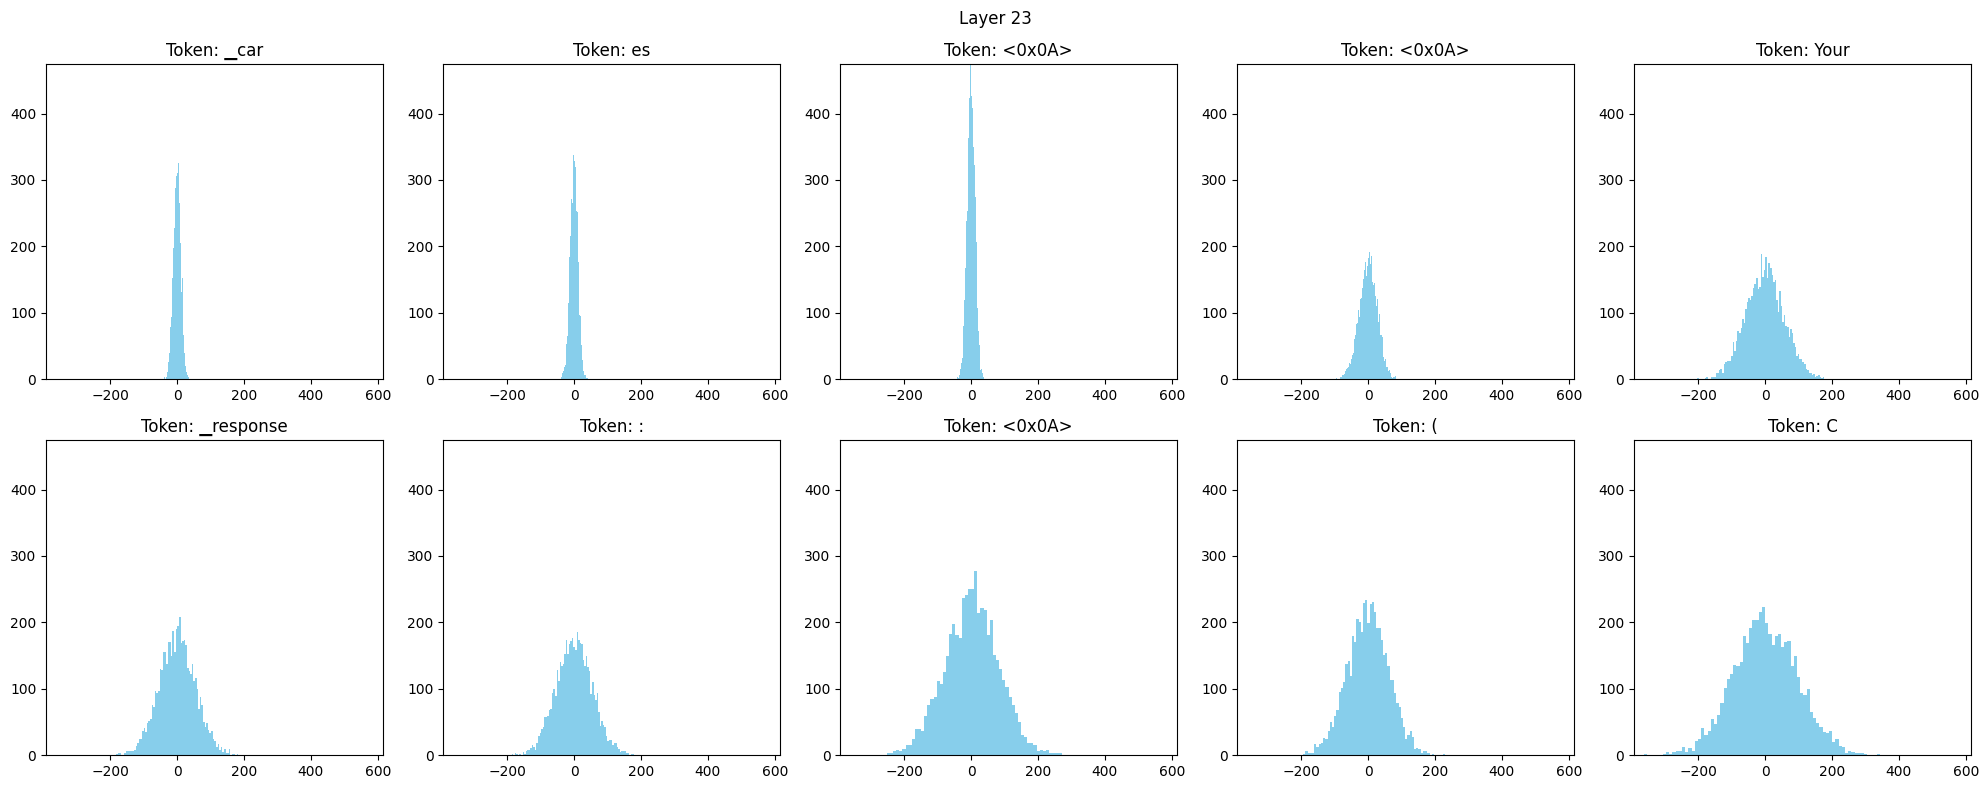

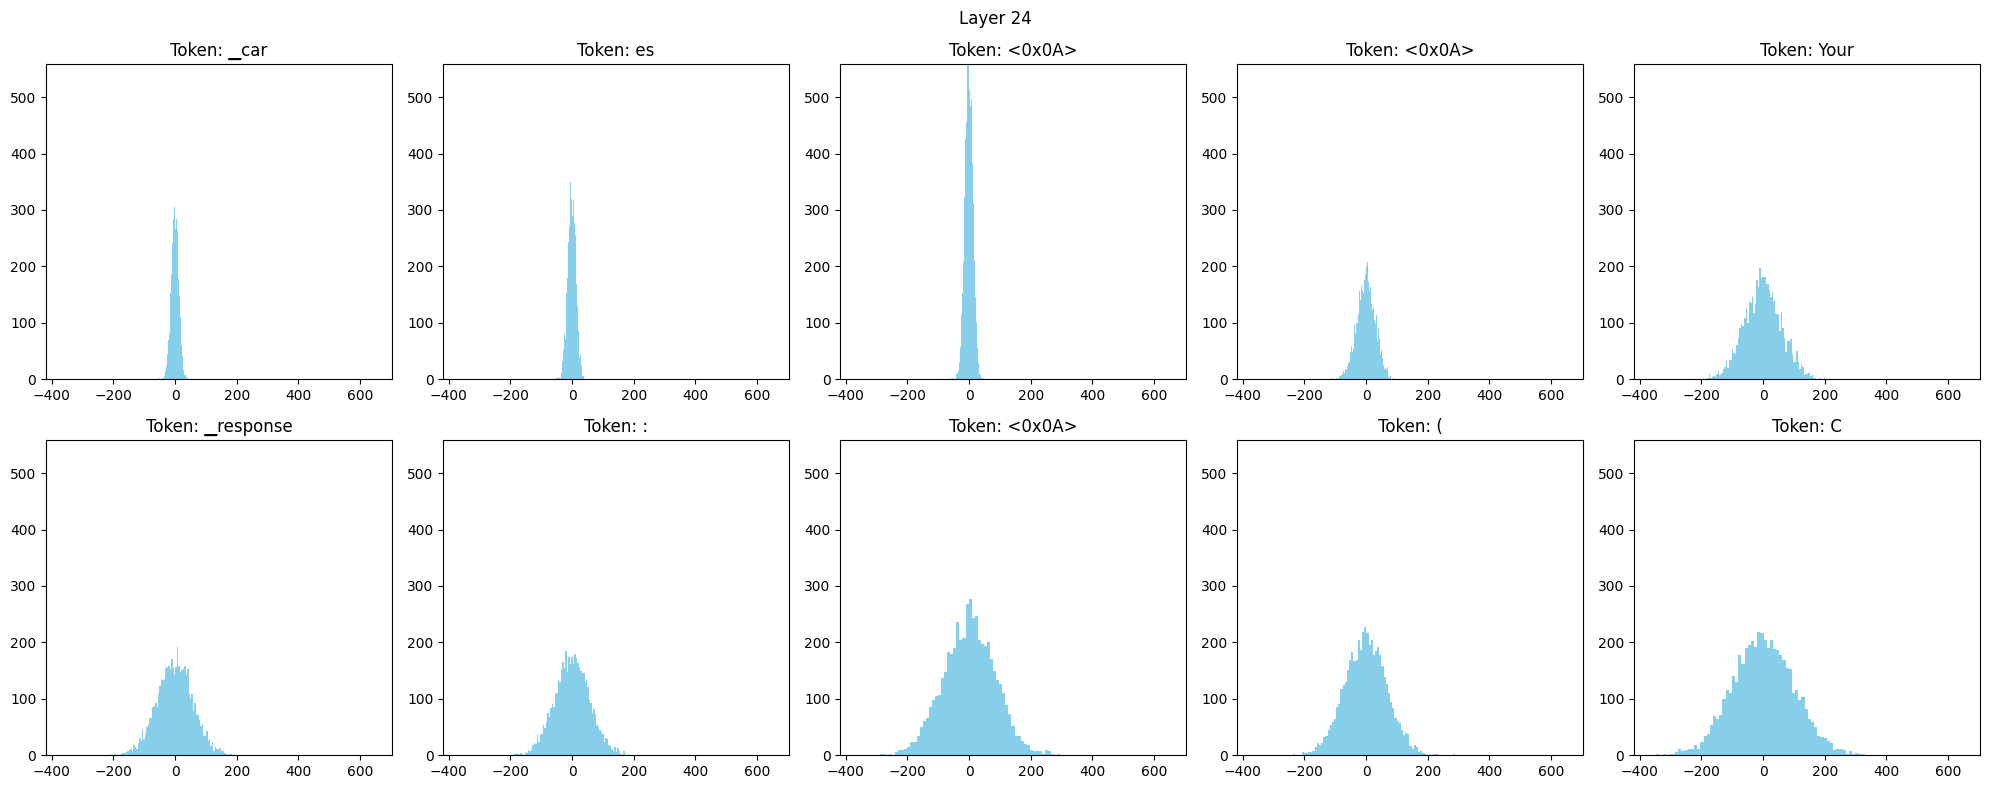

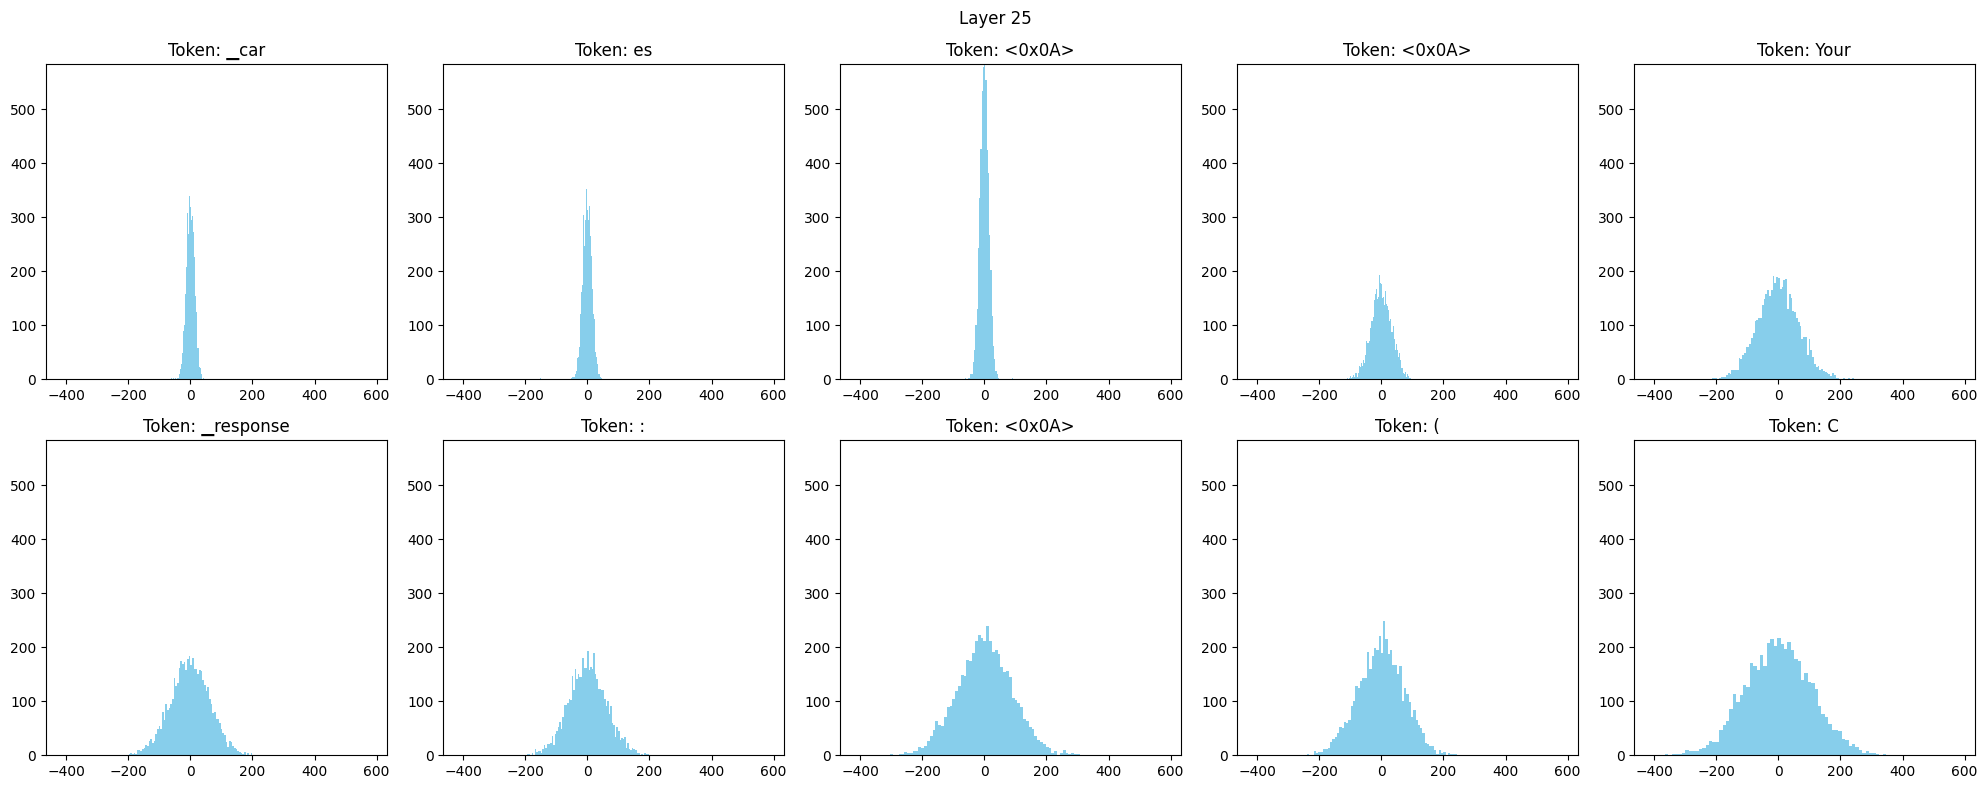

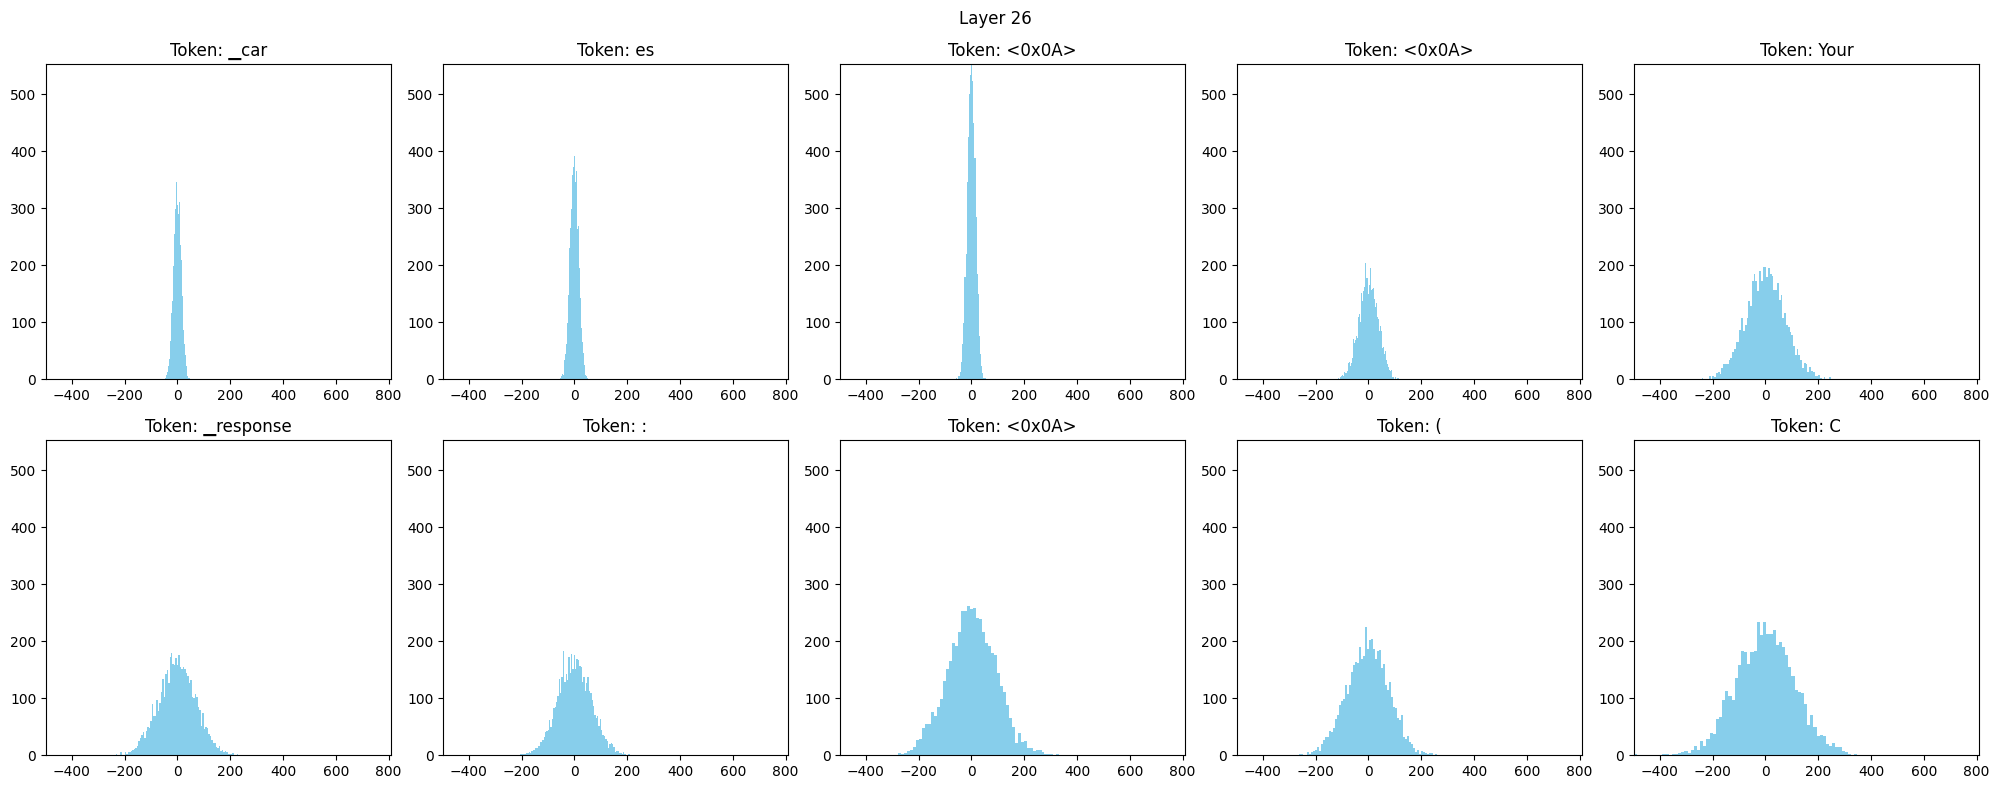

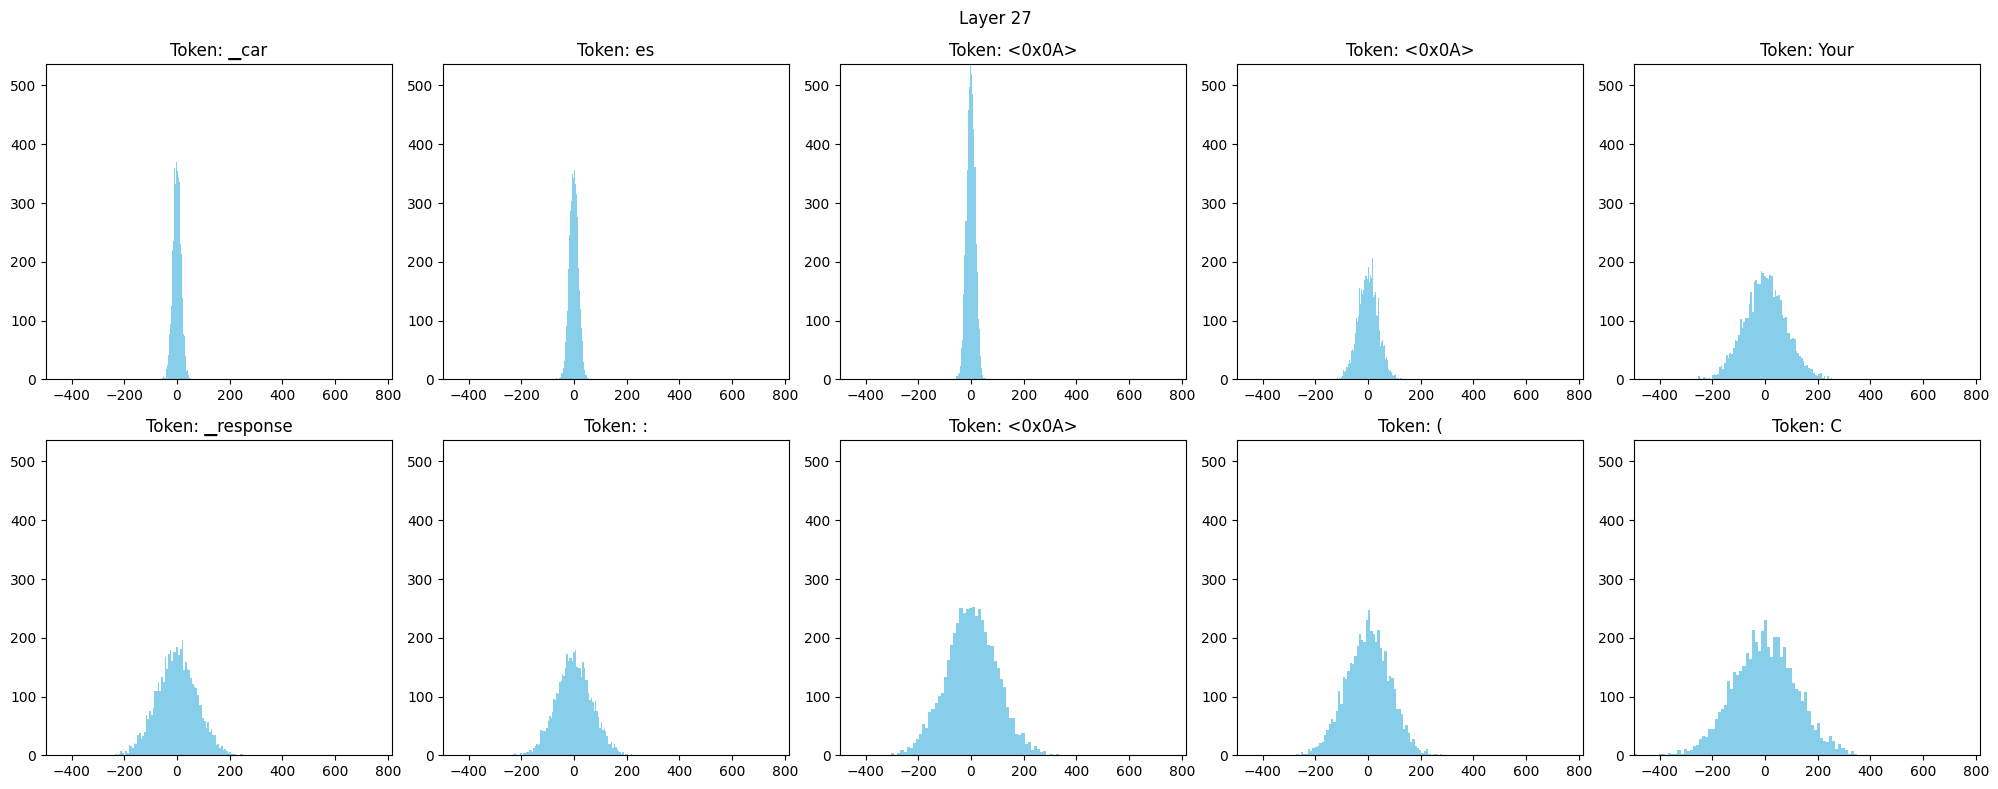

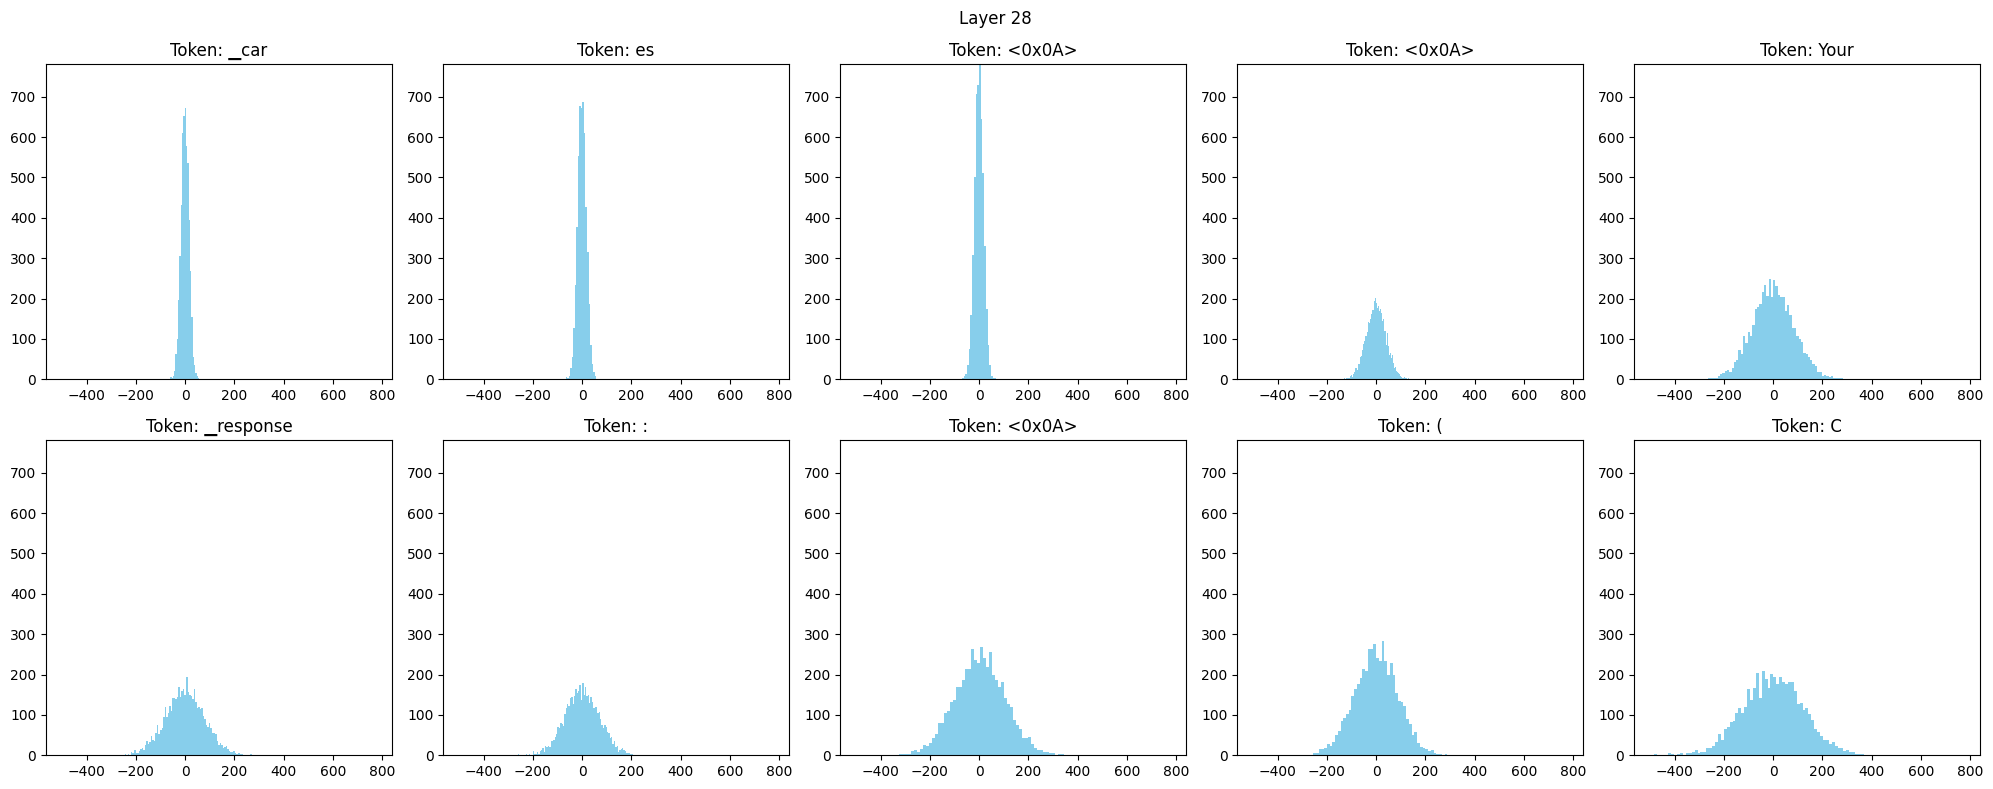

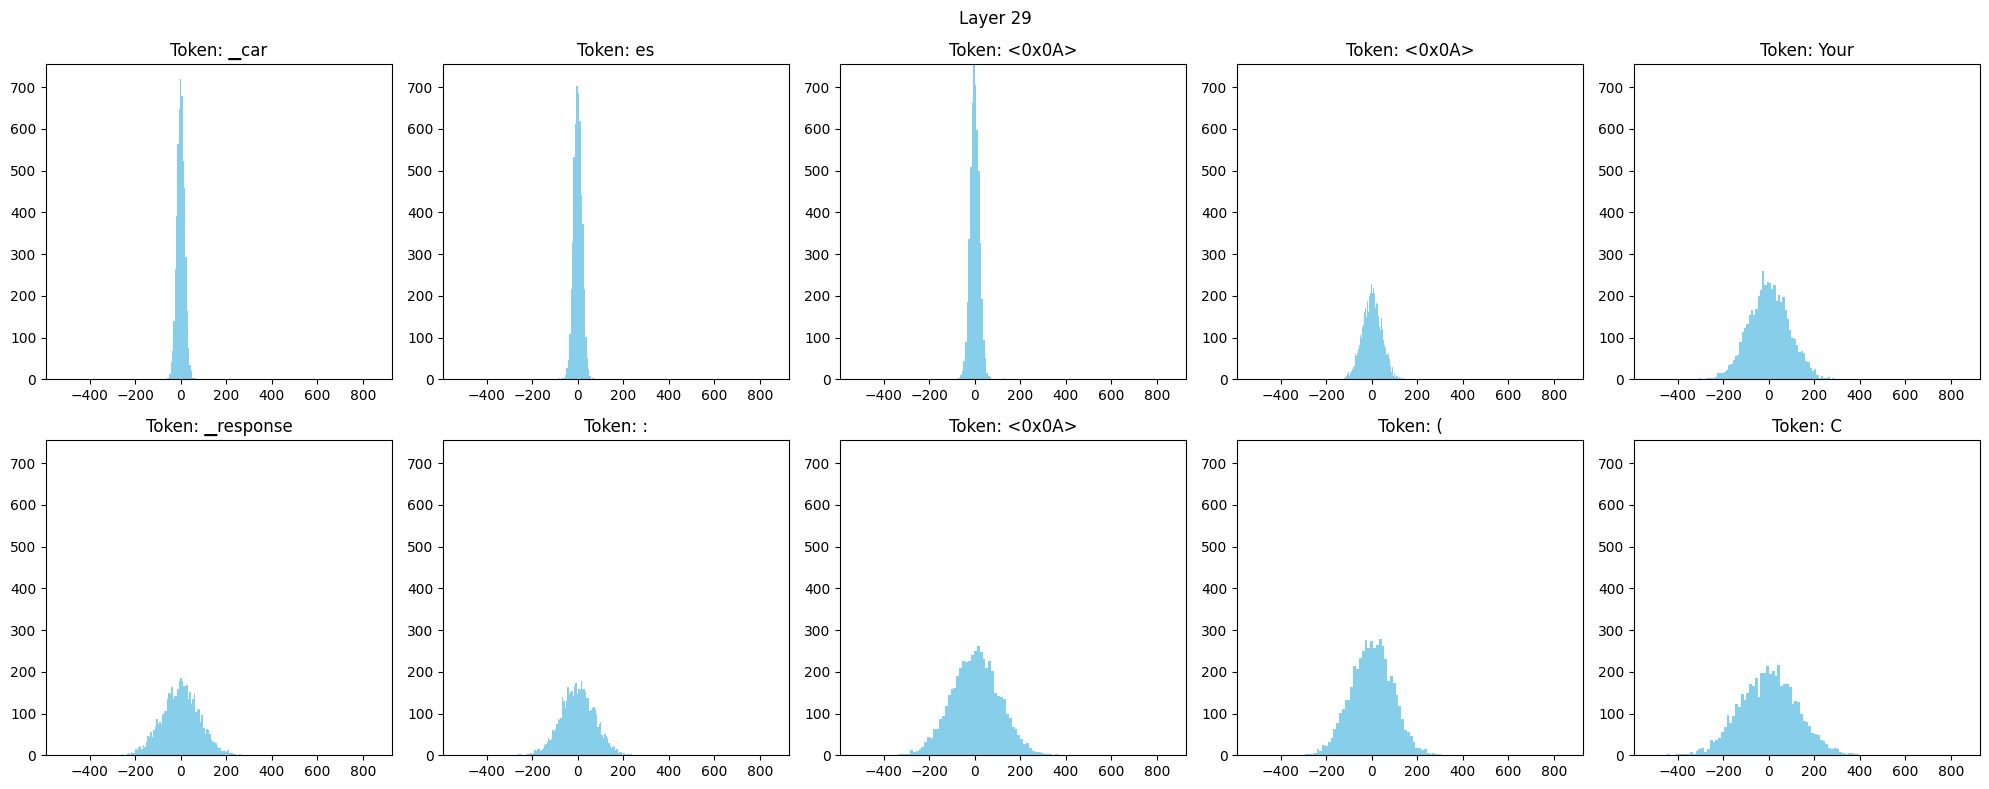

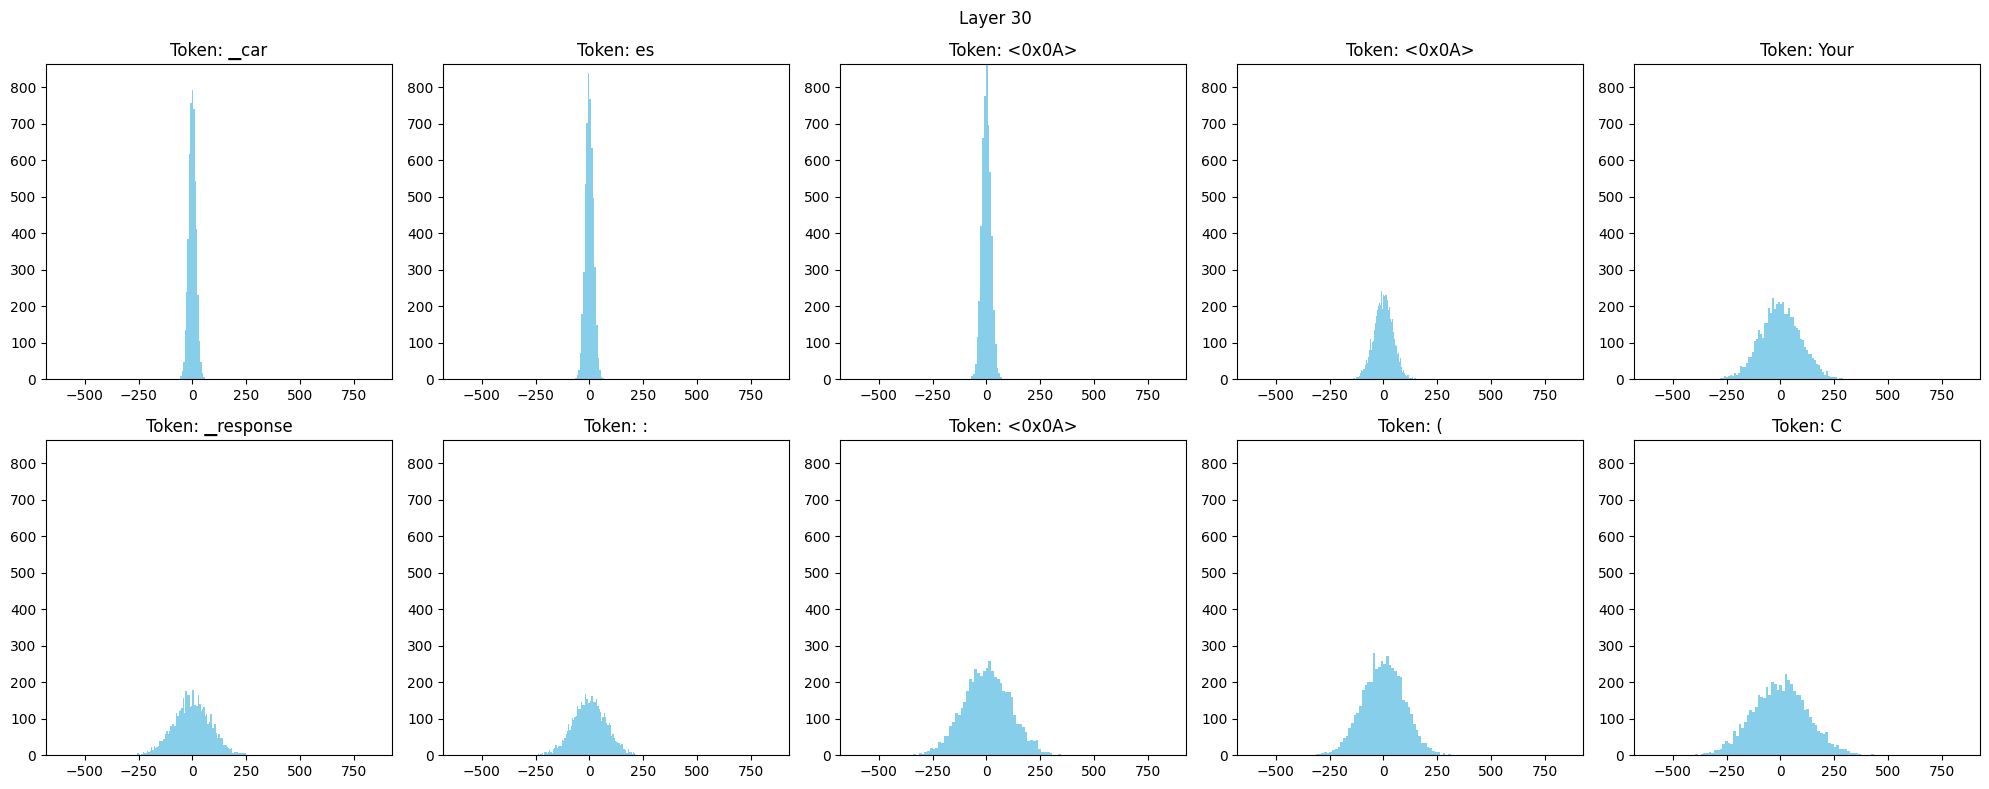

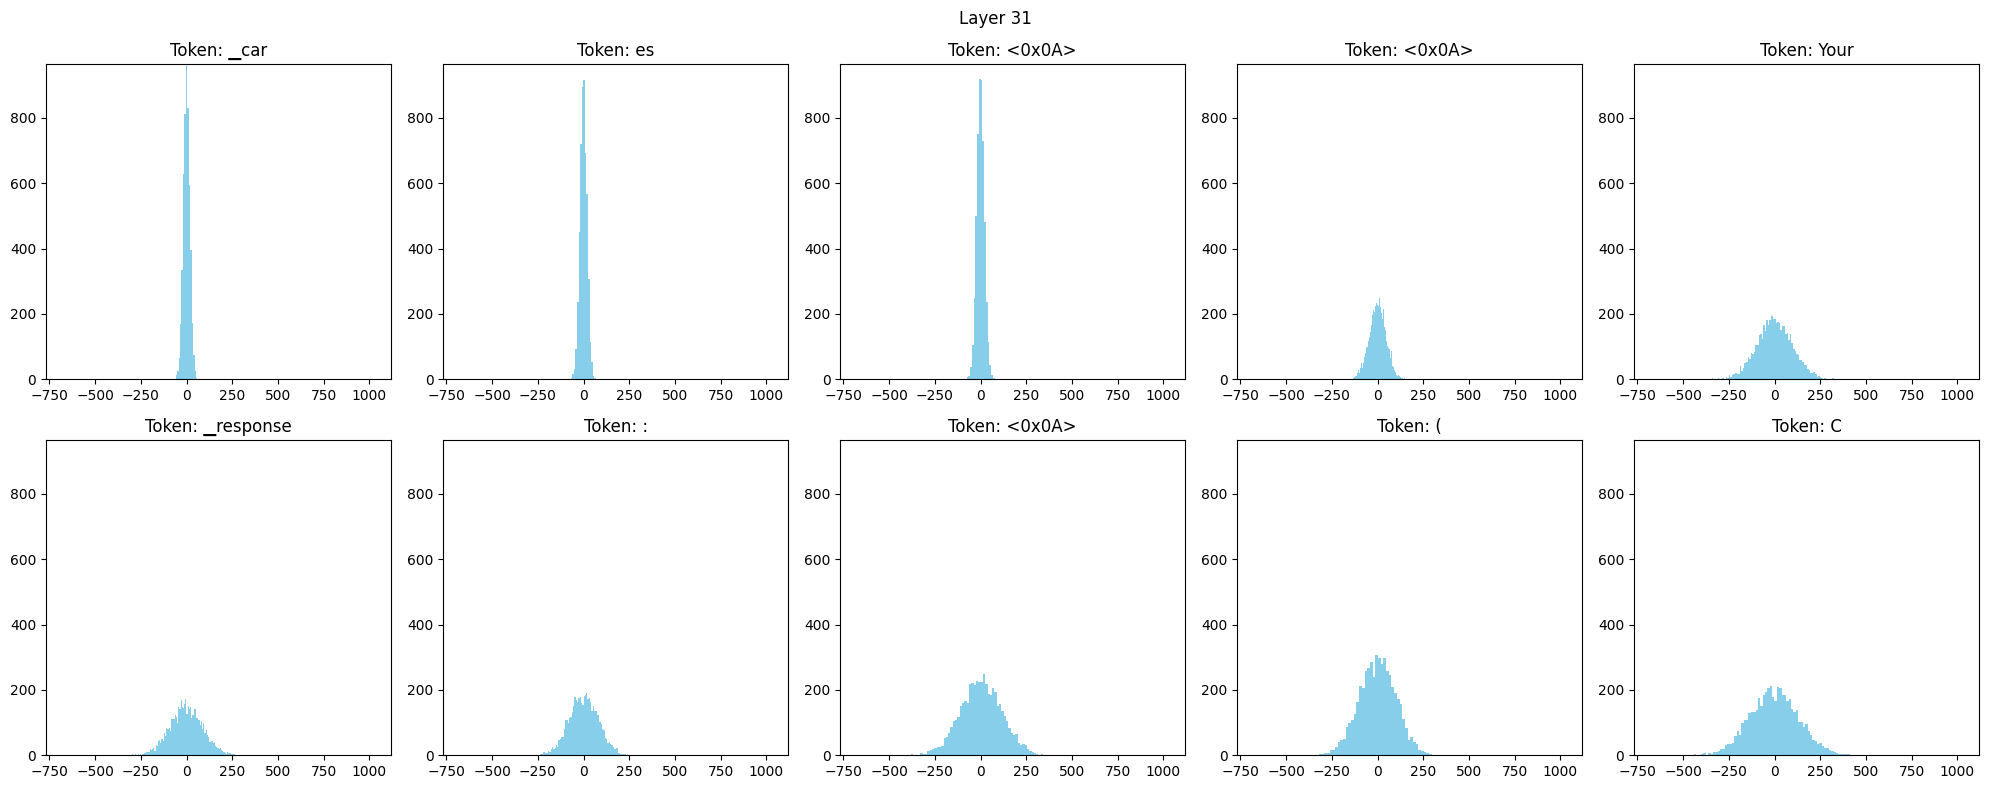

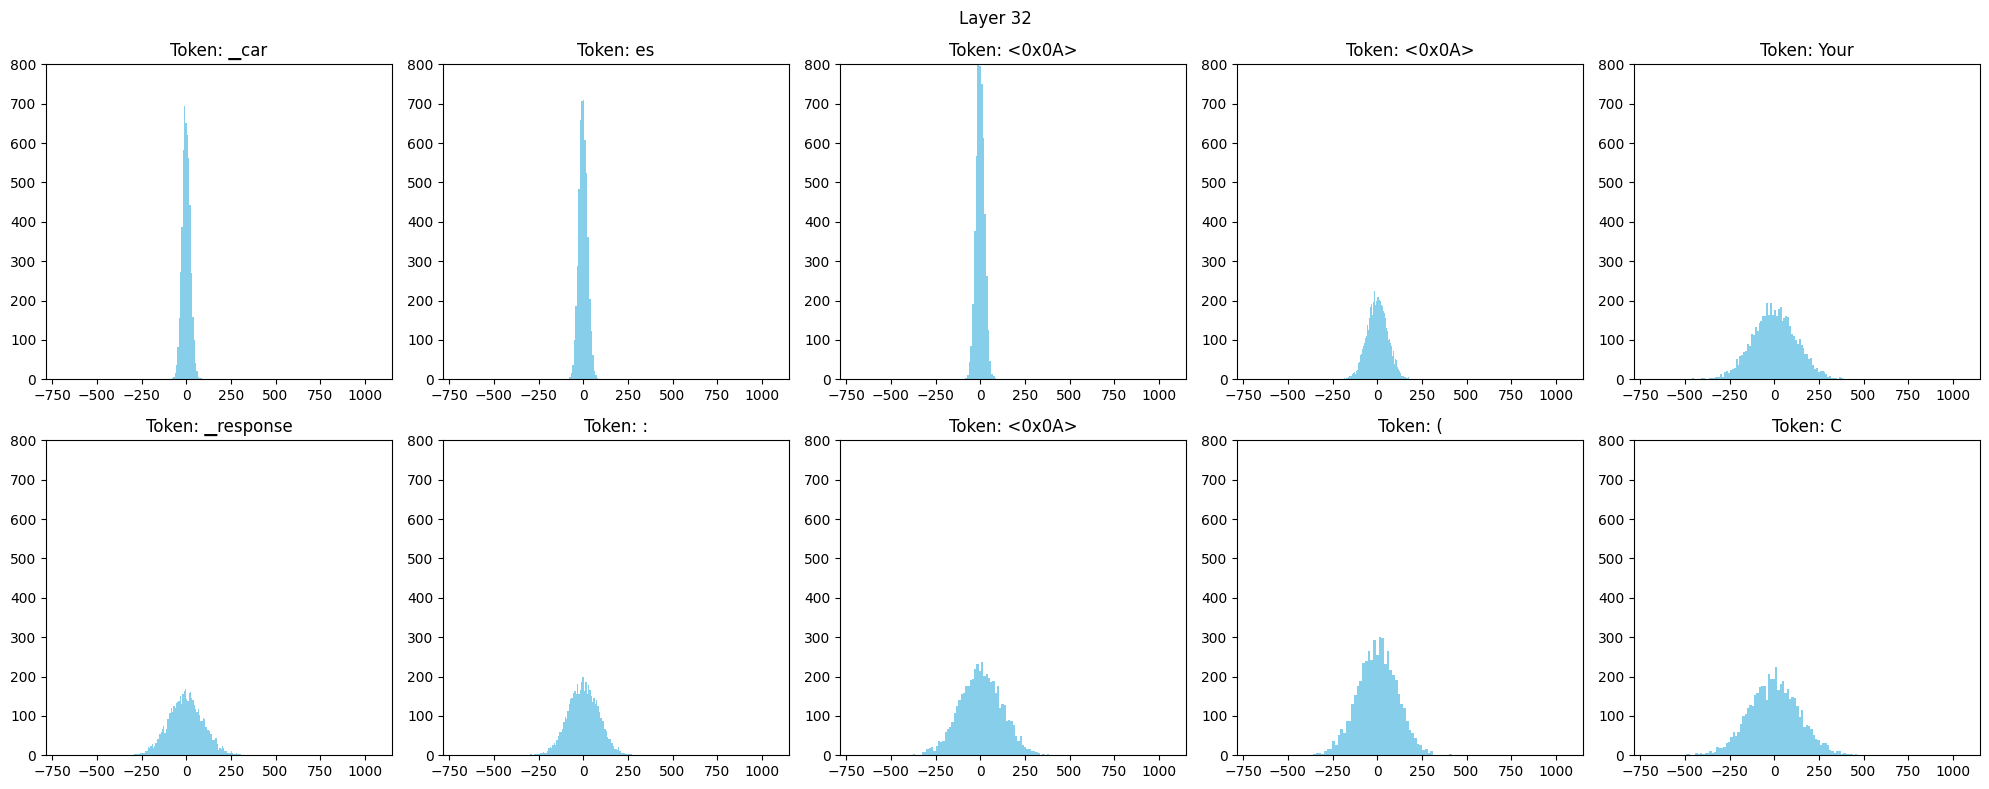

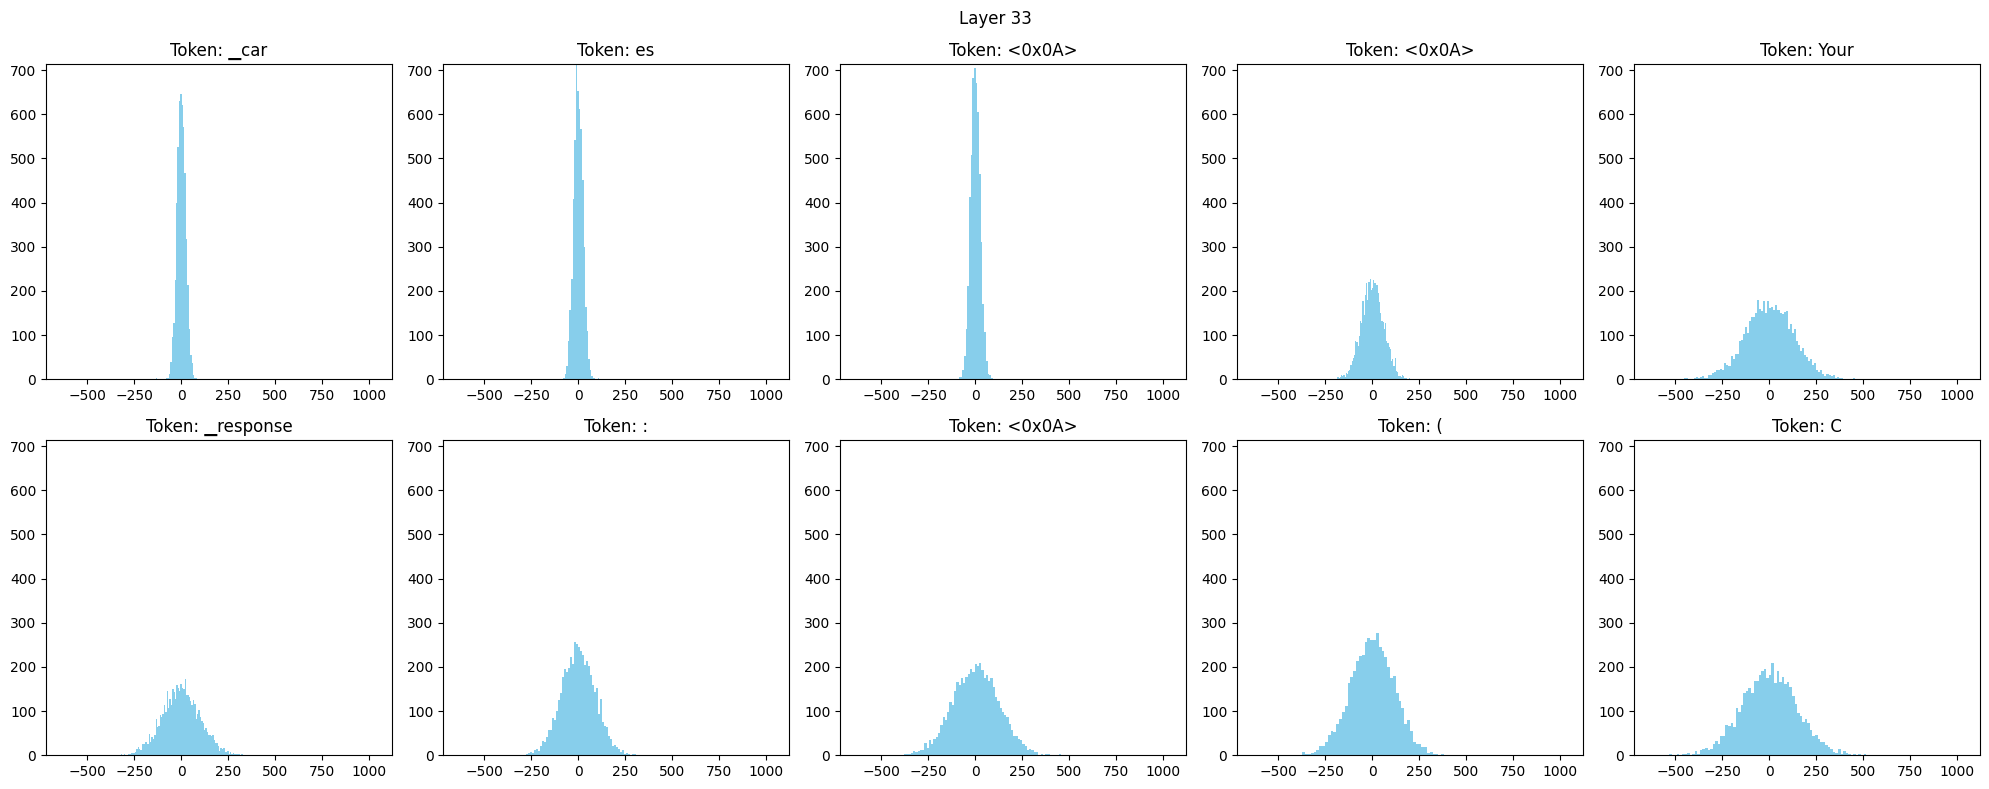

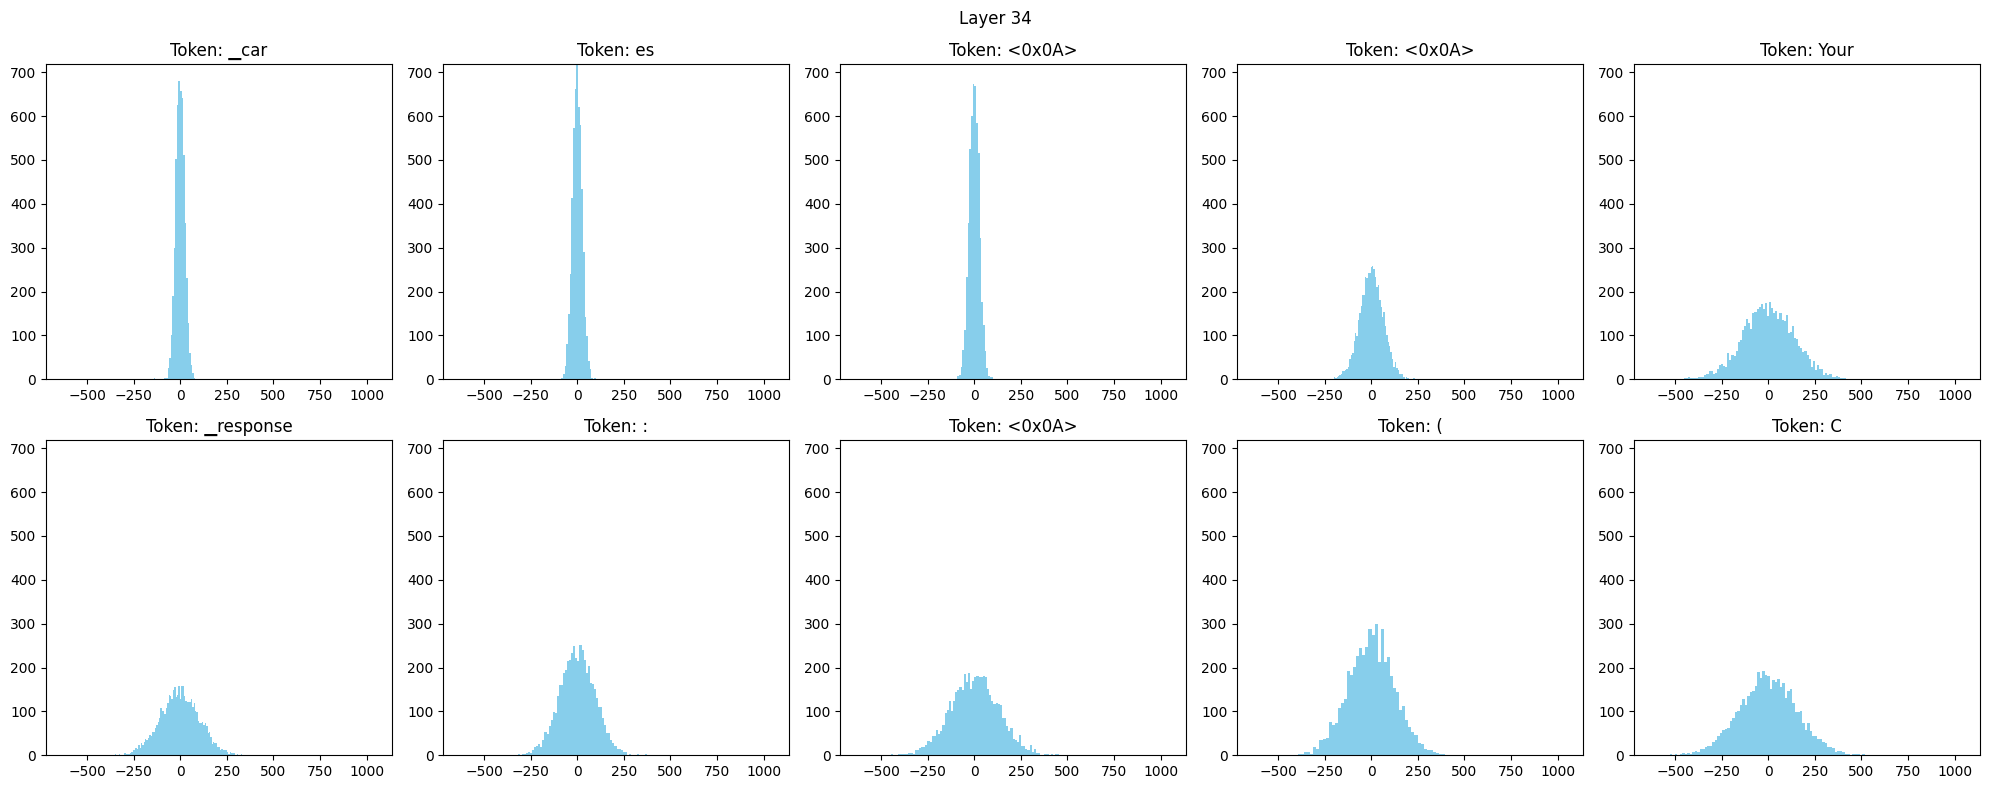

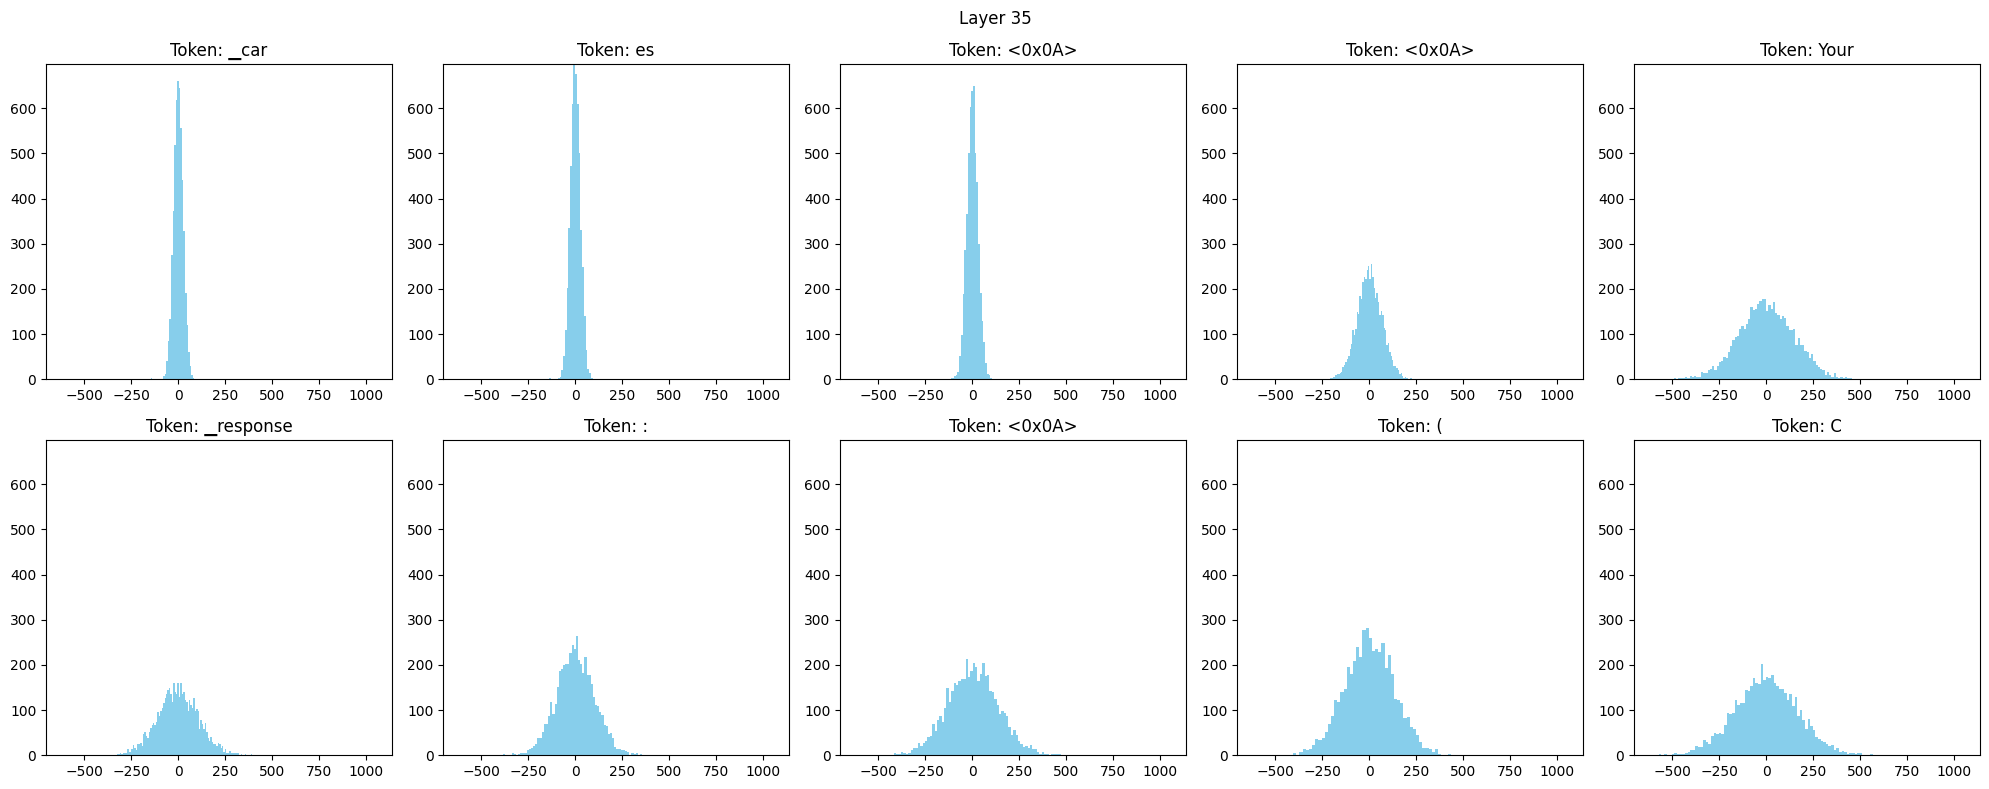

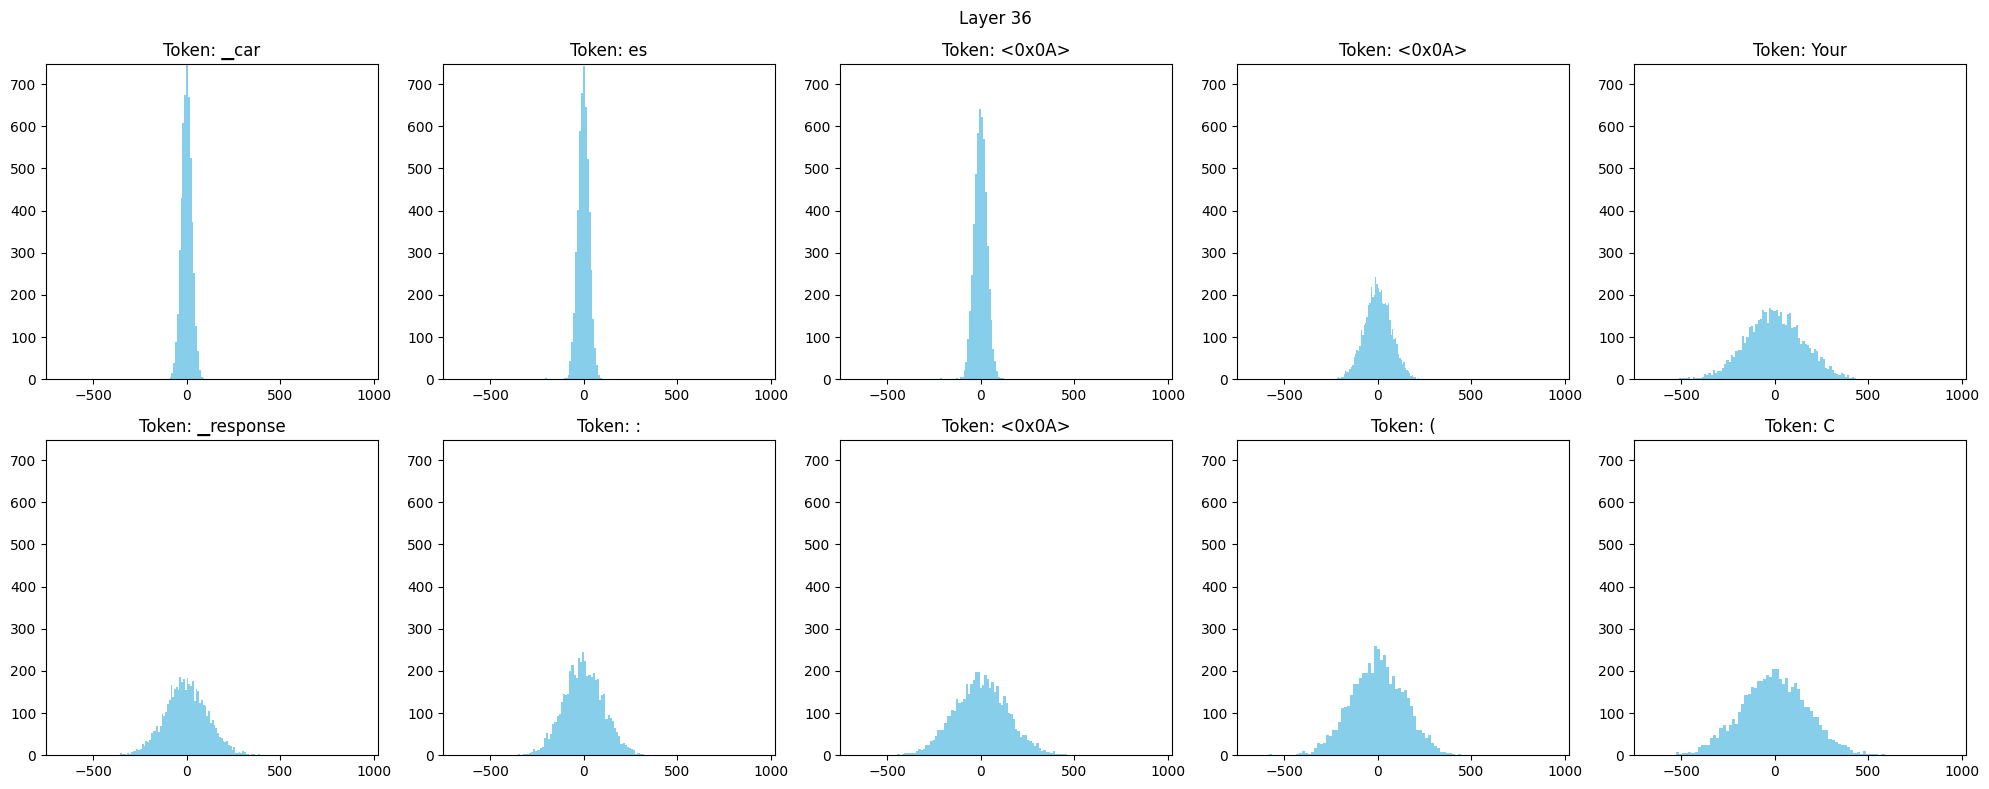

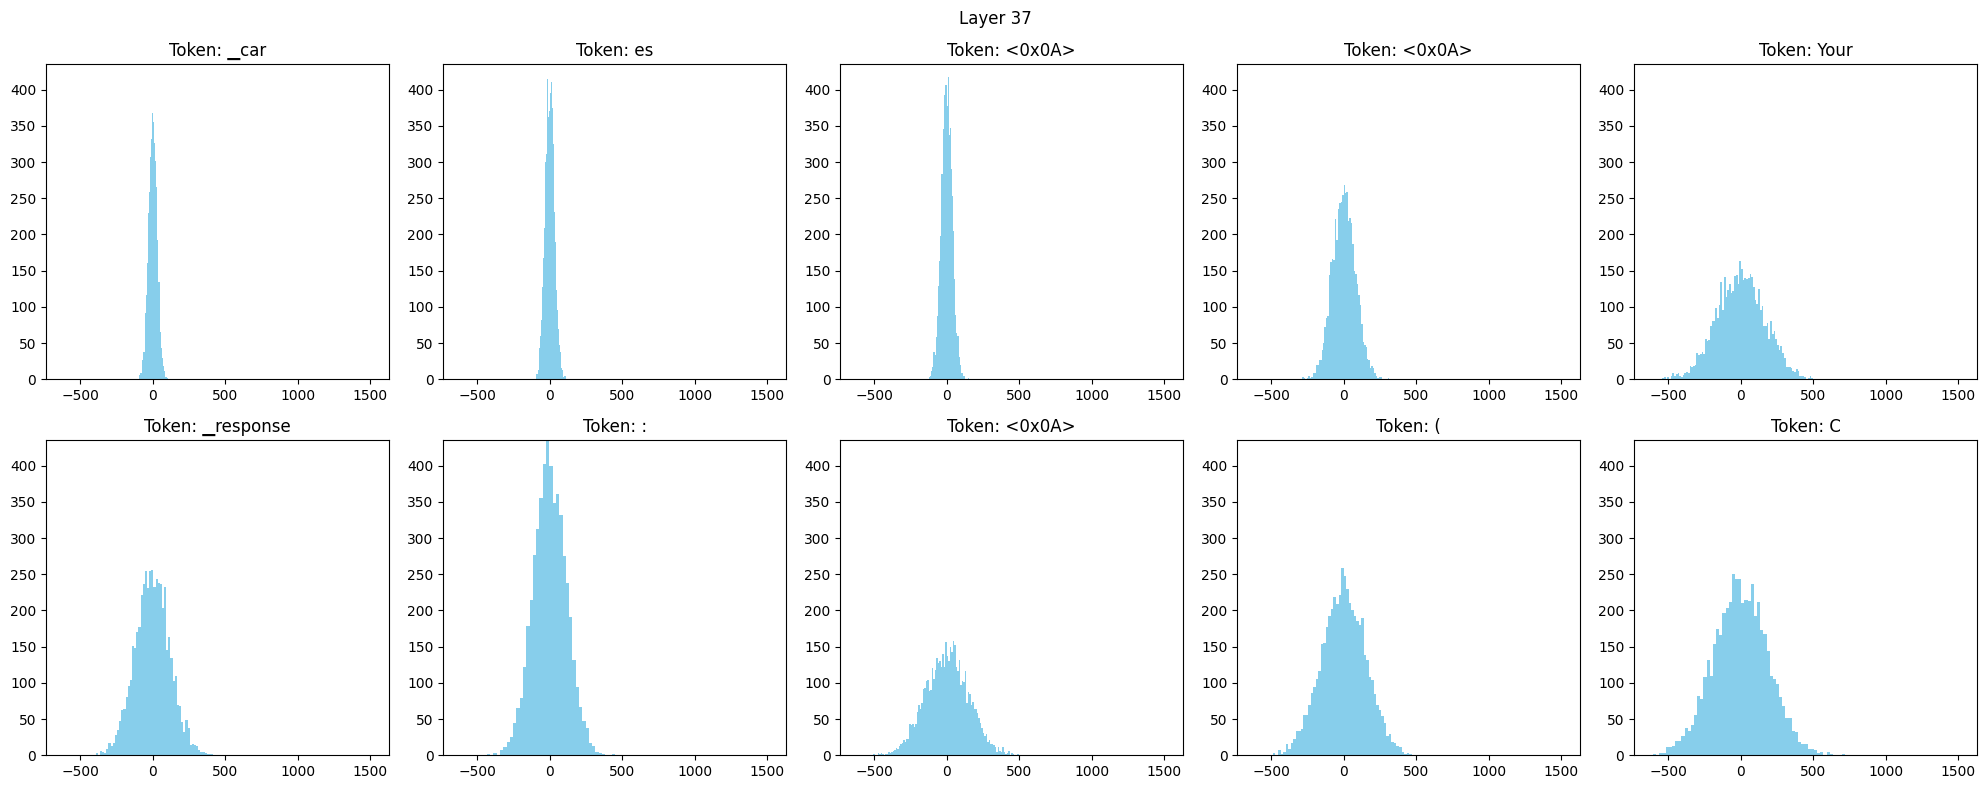

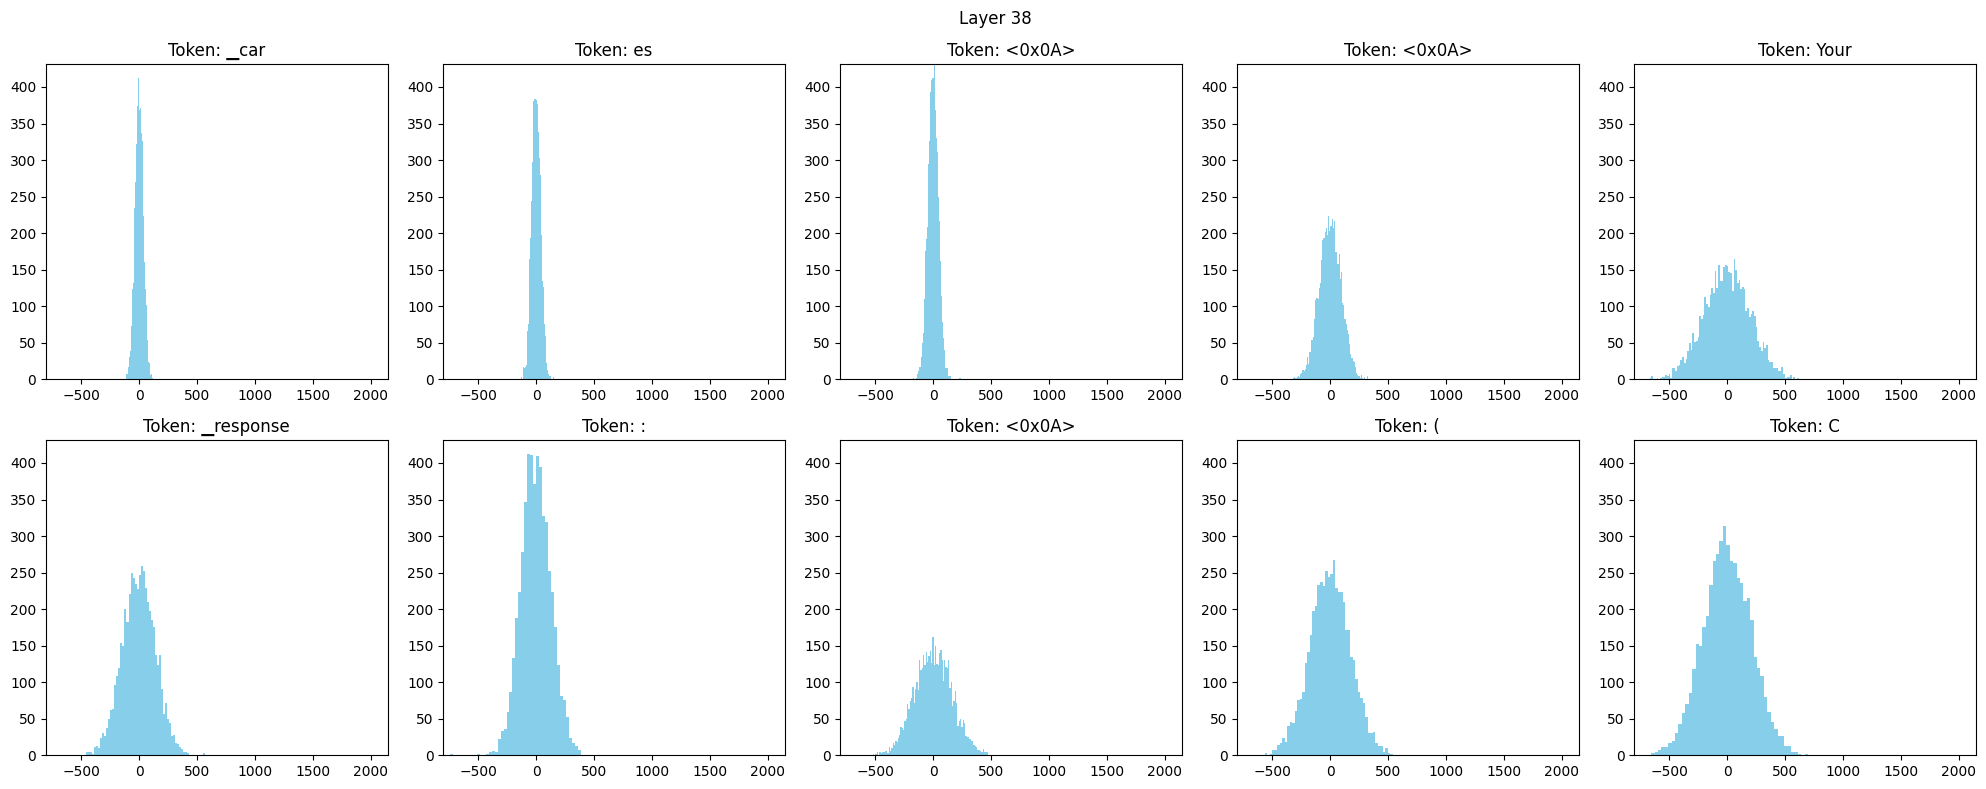

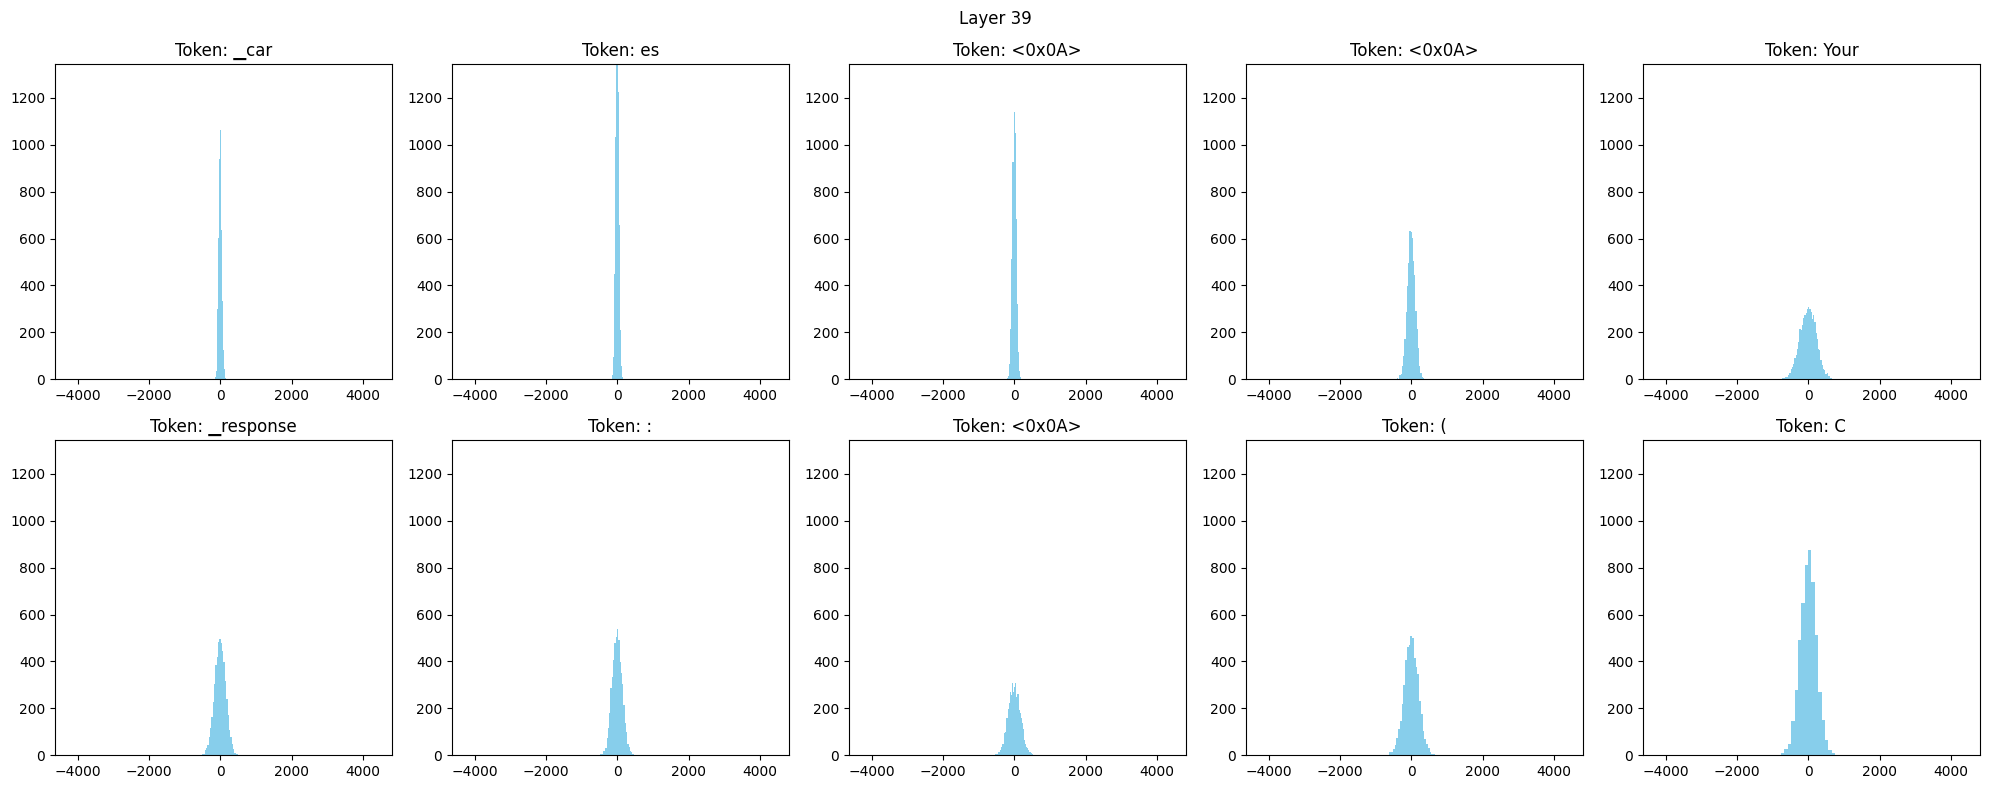

In [16]:
example_seq = model.tokenizer(clean_lenient_seqs[0])["input_ids"]
# Directly convert the last x token IDs to their corresponding strings
token_strings = model.tokenizer.convert_ids_to_tokens(example_seq[-last_x_token_positions:])

for layer_idx in range(steering_vectors.shape[0]):
    layer_data = steering_vectors[layer_idx].cpu()
    
    # Create a figure for the current layer
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # Adjust the figsize as needed
    axs = axs.flatten()  # Flatten the axs array for easy indexing
    
    # Initialize min and max values for xlim and ylim for the current layer
    min_val, max_val = float('inf'), -float('inf')
    hist_data = []
    
    # Collect histogram data to determine common xlim and ylim
    for vector_idx in range(layer_data.shape[0]):
        vector_data = layer_data[vector_idx]
        counts, bins = np.histogram(vector_data, bins=100)
        hist_data.append((counts, bins))
        min_val = min(min_val, bins.min())
        max_val = max(max_val, bins.max())
    
    # Plot histograms for each vector in the current layer
    for subplot_idx, (counts, bins) in enumerate(hist_data):
        axs[subplot_idx].hist(bins[:-1], bins, weights=counts, color="skyblue")
        axs[subplot_idx].set_xlim([min_val, max_val])
        # Set a common ylim if needed, based on the max count across vectors in this layer
        max_count = max(counts.max() for counts, bins in hist_data)
        axs[subplot_idx].set_ylim([0, max_count])
        axs[subplot_idx].set_title(f"Token: {token_strings[subplot_idx]}")
    plt.suptitle(f"Layer {layer_idx}")
    plt.tight_layout()
    plt.show()

## Getting the results

In [ ]:
def lenient_and_harsh_seqs_formatting_test(polar_data, begin=0, end=100):
    clean_str_list = [d["prompt"] for d in polar_data if d["label"] == "clean"]
    toxic_str_list = [d["prompt"] for d in polar_data if d["label"] == "toxic"]

    clean_lenient_seqs = [personas['lenient'] + classifier_prompt.format(sequence=d) for d in clean_str_list][begin:end]
    toxic_lenient_seqs = [personas['lenient'] + classifier_prompt.format(sequence=d) for d in toxic_str_list][begin:end]

    clean_harsh_seqs = [personas['harsh'] + classifier_prompt.format(sequence=d) for d in clean_str_list][begin:end]
    toxic_harsh_seqs = [personas['harsh'] + classifier_prompt.format(sequence=d) for d in toxic_str_list][begin:end]

    return clean_lenient_seqs, toxic_lenient_seqs, clean_harsh_seqs, toxic_harsh_seqs

In [ ]:
clean_lenient_seqs, toxic_lenient_seqs, clean_harsh_seqs, toxic_harsh_seqs = lenient_and_harsh_seqs_formatting_test(polar_data, begin=250, end=500,)

clean_lenient_tokens, clean_lenient_last = tokenize_examples(clean_lenient_seqs, model)
toxic_lenient_tokens, toxic_lenient_last = tokenize_examples(toxic_lenient_seqs, model)

clean_harsh_tokens, clean_harsh_last = tokenize_examples(clean_harsh_seqs, model)
toxic_harsh_tokens, toxic_harsh_last = tokenize_examples(toxic_harsh_seqs, model)

NameError: name 'lenient_and_harsh_seqs_formatting_test' is not defined

In [ ]:
# note that the last position in the steering _vectors is the classificaition position, so needs to be matched up for inference still. THIS IS IMPORTANT
lenient_outs = run_persona_steering(
    model=model,
    clean_tokens=clean_lenient_tokens,
    clean_last_tokens=clean_lenient_last,
    toxic_tokens=toxic_lenient_tokens,
    toxic_last_tokens=toxic_lenient_last,
    steering_vectors=steering_vectors,
    save_path="lenient_steering_results_13b_chat.pt",
    layer_list=range(12, 20),
    position_list=range(-10, 0),
    ic_list=[-1, -0.5, 0, 0.5, 1],
    note="testing persona steering for llama 13b",
)

lenient_outs = run_persona_steering(
    model=model,
    clean_tokens=clean_harsh_tokens,
    clean_last_tokens=clean_harsh_last,
    toxic_tokens=toxic_harsh_tokens,
    toxic_last_tokens=toxic_harsh_last,
    steering_vectors=steering_vectors,
    save_path="harsh_steering_results_13b_chat.pt",
    layer_list=range(12, 20),
    position_list=range(-10, 0),
    ic_list=[-1, -0.5, 0, 0.5, 1],
    note="testing persona steering for llama 13b harsh",
)

NameError: name 'clean_lenient_tokens' is not defined

In [ ]:
model.decode()

## For sequence steering

In [ ]:
clean_str_list = [d["prompt"] for d in polar_data if d["label"] == "clean"]
toxic_str_list = [d["prompt"] for d in polar_data if d["label"] == "toxic"]

clean_lenient_seqs = [personas['lenient'] + classifier_prompt.format(sequence=d) for d in clean_str_list]
toxic_lenient_seqs = [personas['lenient'] + classifier_prompt.format(sequence=d) for d in toxic_str_list]

clean_lenient_tokens, clean_lenient_last = tokenize_examples(clean_lenient_seqs, model)
toxic_lenient_tokens, toxic_lenient_last = tokenize_examples(toxic_lenient_seqs, model)

clean_harsh_seqs = [personas['harsh'] + classifier_prompt.format(sequence=d) for d in clean_str_list]
toxic_harsh_seqs = [personas['harsh'] + classifier_prompt.format(sequence=d) for d in toxic_str_list]

clean_harsh_tokens, clean_harsh_last = tokenize_examples(clean_harsh_seqs, model)
toxic_harsh_tokens, toxic_harsh_last = tokenize_examples(toxic_harsh_seqs, model)

In [ ]:
lenient_cache_cache = {}
lenient_logits_cache = {}

harsh_cache_cache = {}
harsh_logits_cache = {}

# for idx, datapoint in tqdm(enumerate(polar_data), total=len(polar_data)):
for idx, datapoint_pair in tqdm(enumerate(zip(clean_lenient_seqs, toxic_lenient_seqs)), total=min(len(clean_lenient_seqs), len(toxic_lenient_seqs))):


    clean_lenient_logits, clean_lenient_cache = get_resid_cache_from_forward_pass(model, model.to_tokens(datapoint_pair[0]))
    clean_lenient_cache = {k: v.cpu().detach() for k, v in clean_lenient_cache.items()}

    toxic_lenient_logits, toxic_lenient_cache = get_resid_cache_from_forward_pass(model, model.to_tokens(datapoint_pair[1]))
    toxic_lenient_cache = {k: v.cpu().detach() for k, v in toxic_lenient_cache.items()}

    lenient_cache_cache[idx] = {"clean": clean_lenient_cache, "toxic": toxic_lenient_cache, "clean_seq": datapoint_pair[0], "toxic_seq": datapoint_pair[1]}

    torch.save(lenient_cache_cache, "lenient_cache_cache.pt")

    break

for idx, datapoint_pair in tqdm(enumerate(zip(clean_harsh_seqs, toxic_harsh_seqs)), total=min)(len(clean_harsh_seqs), len(toxic_harsh_seqs)):

    clean_harsh_logits, clean_harsh_cache = get_resid_cache_from_forward_pass(model, model.to_tokens(datapoint_pair[0]))
    clean_harsh_cache = {k: v.cpu().detach() for k, v in clean_harsh_cache.items()}

    toxic_harsh_logits, toxic_harsh_cache = get_resid_cache_from_forward_pass(model, model.to_tokens(datapoint_pair[1]))
    toxic_harsh_cache = {k: v.cpu().detach() for k, v in toxic_harsh_cache.items()}

    harsh_cache_cache[idx] = {"clean": clean_harsh_cache, "toxic": toxic_harsh_cache, "clean_seq": datapoint_pair[0], "toxic_seq": datapoint_pair[1]}

    torch.save(harsh_cache_cache, "harsh_cache_cache.pt")

    break

# with open("cache_cache.json", "w") as f:
#     json.dump(cache_cache, f)

# with open("logits_cache.json", "w") as f:
#     json.dump(logits_cache, f)


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]



In [ ]:
harsh_cache_cache

{0: {'clean': {'blocks.0.hook_resid_post': tensor([[[-0.0215, -0.0043,  0.0376,  ...,  0.0098,  0.0101,  0.0237],
            [-0.0052,  0.0145,  0.0154,  ...,  0.0131,  0.0096,  0.0038],
            [ 0.0435,  0.0141, -0.0200,  ..., -0.0210, -0.0297, -0.0129],
            ...,
            [-0.0121,  0.0058,  0.0073,  ...,  0.0187, -0.0084, -0.0133],
            [ 0.0031,  0.0400, -0.0024,  ..., -0.0237, -0.0085, -0.0291],
            [-0.0332,  0.0094, -0.0016,  ..., -0.0193, -0.0157, -0.0166]]],
          dtype=torch.bfloat16),
   'blocks.1.hook_resid_post': tensor([[[-0.0369, -0.0051,  0.0537,  ..., -0.0082,  0.0193,  0.0201],
            [ 0.0003,  0.0496,  0.0034,  ..., -0.0203,  0.0165,  0.0056],
            [ 0.0659,  0.0461, -0.0435,  ..., -0.0654, -0.0305, -0.0028],
            ...,
            [-0.0228,  0.0164, -0.0084,  ...,  0.0132, -0.0094, -0.0337],
            [-0.0087,  0.0322, -0.0327,  ..., -0.0149, -0.0072, -0.0386],
            [-0.0232, -0.0203, -0.0425,  ..., -0.

In [ ]:
import pickle
print("pickling the cache_cache")
with open('cache_cache.pkl', 'wb') as f:
    pickle.dump(cache_cache, f)
print("alright now gawjus, time to pickle the logits cache!, wee ooh ye")
with open("logits_cache.pkl", "wb") as f:
    pickle.dump(logits_cache, f)

In [ ]:

with open("cache_cache.pkl", "rb") as f:
    cache_cache = pickle.load(f)

with open("logits_cache.pkl", "rb") as f:
    logits_cache = pickle.load(f)

In [ ]:
# layers, tokens, hidden_dim
steering_vectors = torch.zeros((model.cfg.n_layers, 10, model.cfg.d_model))
train_size = int(0.5 * len(cache_cache))
for key, val in cache_cache.items():
    if key > train_size:
        break
    lenient_cache = val["lenient"]
    harsh_cache = val["harsh"]
    for layer in range(model.cfg.n_layers):
        lenient_layer_cache = lenient_cache[f"blocks.{layer}.hook_resid_post"]
        harsh_layer_cache = harsh_cache[f"blocks.{layer}.hook_resid_post"]
        # batch, tokens, hidden_dim
        steering_vectors[layer] += lenient_layer_cache[0, :10, :] - harsh_layer_cache[0, :10, :]

steering_vectors /= train_size


In [ ]:
torch.cuda.empty_cache()

In [ ]:
outs = run_steering(
    model=model,
    pos_batched_dataset=lenient_tokens,
    pos_lasts=lenient_last,
    neg_batched_dataset=harsh_tokens,
    neg_lasts=harsh_last,
    steering_vectors=steering_vectors,
)

In [ ]:
outs[2][0][-5].keys()

dict_keys(['pos_preds', 'neg_preds', 'pos_pred_probs', 'neg_pred_probs'])

In [ ]:
torch.save(outs, "outs.pt")

In [ ]:
out = torch.load("steering_results.pt")

In [ ]:
torch.save(steering_vectors, "steering_vectors.pt")

: 